In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, bin_data_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename
import backends.plot as plot

print("Importing tensorflow and keras")
import tensorflow    as tf
from   keras.layers  import Input, Concatenate, Lambda
from   keras.models  import Model
import keras.backend as     K


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Importing tensorflow and keras


In [2]:
#  Inputs config

input_fname_EWK = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fname_QCD = "../Data/SM_QCD_rivet_output.pickle"

load_model_EWK = ".EWK_density_model"
load_model_QCD = ".QCD_density_model"

load_whitening_funcs = ".whitening_funcs.pickle"

L                   = 140e3        # integrated luminosity in /pb
n_gen_EWK           = int(25000)   # number of events to importance sample from EWK baseline
n_gen_QCD           = int(25000)   # number of events to importance sample from QCD baseline
weight_fraction_EWK = 0.98         # relative weight to give to events importance sampled from EWK baseline

n_gen_EWK_toys      = int(200000)
n_gen_QCD_toys      = int(0)
weight_fraction_EWK_toys = 0

In [3]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [4]:
#  Load and format the data
#

print(f"Creating QCD data table")
print(f" -- events from file {input_fname_QCD}")
data_table_QCD = DataTable(input_fname_QCD)
print(f" -- Table created with {data_table_QCD.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_QCD.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_QCD.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_QCD.remove_column(observable)
print(" -- ordering observables")
data_table_QCD.reorder(*observables_order)
data_table_QCD.print_summary()

print(f"Creating EWK data table")
print(f" -- events from file {input_fname_EWK}")
data_table_EWK = DataTable(input_fname_EWK)
print(f" -- Table created with {data_table_QCD.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_EWK.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_EWK.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_EWK.remove_column(observable)
print(" -- ordering observables")
data_table_EWK.reorder(*observables_order)
data_table_EWK.print_summary()
    

Creating QCD data table
 -- events from file ../Data/SM_QCD_rivet_output.pickle
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 126626 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 126625 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 126625 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 123851 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 120416 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 120416 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 120416 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 120416 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 120409 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 120349 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 120349 events survived
 -- 

In [5]:

#data_table_QCD.xsec_per_event = 0.

sigma_EWK = data_table_EWK.xsec_per_event * data_table_EWK.get_sum_weights()
sigma_QCD = data_table_QCD.xsec_per_event * data_table_QCD.get_sum_weights()
sigma_tot = sigma_EWK+sigma_QCD


In [6]:
#  Load ability to whiten/unwhiten datapoints
#

print(f"Loading whitening functions from file {load_whitening_funcs}")
whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))


Loading whitening functions from file .whitening_funcs.pickle


In [7]:
#  Load EWK and QCD density models
#

density_model_EWK = DensityModel.from_dir(load_model_EWK)
for m in density_model_EWK.likelihood_models :
    m.model.summary()

density_model_QCD = DensityModel.from_dir(load_model_QCD)
for m in density_model_QCD.likelihood_models :
    m.model.summary()


INFO       DensityModel.construct      Set model name           : dflt
INFO       DensityModel.construct      Set model num_gaussians  : 2
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 1
INFO       DensityModel.construct      Set observable types     : [<class 'float'>]
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 7)            14          input_2[0][0]                    
___________________________________

Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 7)            14          input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 7)            0           dense_46[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 30)           240         leaky_re_lu_28[0][0]             
______________________________________________________________________

In [8]:
#  Create logL models using tf and keras for speed
#

ng = 15
sqrt_2pi = np.sqrt(2*np.pi)

def K_gauss_prob (x, mean, sigma) :
    return K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)

def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    #x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob

def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
        
def K_dataset_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_dataset_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_get_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_likelihood (eval_p, params_p, ng)

def K_get_log_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, ng)

def combine_EWK_QCD_log_likelihoods (inputs) :
    logL_EWK, logL_QCD = inputs[0], inputs[1]
    return K.log((sigma_EWK*K.exp(logL_EWK) + sigma_QCD*K.exp(logL_QCD)) / sigma_tot)


EWK_models = [x.model for x in density_model_EWK.likelihood_models]
QCD_models = [x.model for x in density_model_QCD.likelihood_models]

for model in EWK_models :
    model.name = model.name.replace("QCD", "EWK")
    for layer in model.layers :
        layer.name = layer.name.replace("QCD", "EWK")

condition_input_layer_cWtil = Input((1,), name="cWtil_input")
condition_input_layer_QCD   = Input((1,), name="QCD_input")
obs_input_layer             = Input((num_observables,), name="observable_input")

EWK_logL_layers, QCD_logL_layers = [], []

for i, (EWK_model, QCD_model) in enumerate(zip(EWK_models, QCD_models)) :
    model_inputs_EWK = [condition_input_layer_cWtil]
    model_inputs_QCD = [condition_input_layer_QCD  ]
    if i > 0 :
        cond_obs_split_layer = Lambda(lambda x : x[:, :i], name=f"split_observable_below{i}")(obs_input_layer)
        model_inputs_EWK.append(cond_obs_split_layer)
        model_inputs_QCD.append(cond_obs_split_layer)
    EWK_params = EWK_model(model_inputs_EWK)
    QCD_params = QCD_model(model_inputs_QCD)
    eval_p     = Lambda(lambda x : x[:, i], name=f"split_observable_eq{i}")(obs_input_layer)
    EWK_logL_layers.append(Lambda(K_get_log_likelihood, name=f"EWK_logL_observable{i}")([eval_p, EWK_params]))
    QCD_logL_layers.append(Lambda(K_get_log_likelihood, name=f"QCD_logL_observable{i}")([eval_p, QCD_params]))

# combine layers
EWK_logL = Lambda(lambda x : tf.add_n(x), name="EWK_logL_total")(EWK_logL_layers)
QCD_logL = Lambda(lambda x : tf.add_n(x), name="QCD_logL_total")(QCD_logL_layers)

QCD_logL_model = Model([condition_input_layer_QCD, obs_input_layer], QCD_logL)
QCD_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

EWK_logL_model = Model([condition_input_layer_cWtil, obs_input_layer], EWK_logL)
EWK_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

# combine EWK and QCD
QCD_precomputed_logL = Input((1,), name="QCD_logL_input")
QCD_precomputed_logL_reshaped = Lambda(lambda x : x[:,0], name="QCD_logL_input_reshaped")(QCD_precomputed_logL)
dataset_logL   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_full")([EWK_logL, QCD_precomputed_logL_reshaped])
EvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, QCD_precomputed_logL, obs_input_layer],
                       outputs = dataset_logL)
EvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

# combine EWK and QCD
dataset_logL_alt   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_partial")([EWK_logL, QCD_logL])
FullEvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, condition_input_layer_QCD, obs_input_layer],
                           outputs = dataset_logL_alt)
FullEvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 



In [44]:
#  Define and run function which samples a new Asimov

fake_datapoint_weights, fake_white_datapoints, sum_weights, QCD_logL, QCD_L, EWK_logL, EWK_L, dummy_zeros = None, None, None, None, None, None, None, None

def generate_asimov(n_gen_EWK, n_gen_QCD, weight_fraction_EWK=-1) :
    global fake_datapoint_weights, fake_white_datapoints, sum_weights, QCD_logL, QCD_L, EWK_logL, EWK_L, dummy_zeros
    n_gen = n_gen_EWK + n_gen_QCD
    assert n_gen > 0

    #  Generate a large number of EWK and QCD datapoints at 0.
    #

    print(f"Generating {n_gen} fake datapoints")
    start = time.time()
    fake_white_datapoints_from_EWK = density_model_EWK.sample(n_gen_EWK, [0])
    fake_white_datapoints_from_QCD = density_model_QCD.sample(n_gen_QCD, [0])
    print(f"{n_gen} datapoints generated at cWtil=0 in {int(time.time()-start):.0f}s")

    #  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

    start       = time.time()
    dummy_zeros_from_EWK, dummy_zeros_from_QCD = np.zeros(n_gen_EWK), np.zeros(n_gen_QCD)
    QCD_logL_from_EWK = QCD_logL_model.predict([dummy_zeros_from_EWK, fake_white_datapoints_from_EWK], verbose=0)
    QCD_L_from_EWK    = np.exp(QCD_logL_from_EWK)
    QCD_logL_from_QCD = QCD_logL_model.predict([dummy_zeros_from_QCD, fake_white_datapoints_from_QCD], verbose=0)
    QCD_L_from_QCD    = np.exp(QCD_logL_from_QCD)
    print(f"QCD logL computed in {time.time()-start:.2f}s")

    #  Compute logL_EWK here (to help with datapoint reweighting)

    start    = time.time()
    EWK_logL_from_EWK = EWK_logL_model.predict([dummy_zeros_from_EWK, fake_white_datapoints_from_EWK], verbose=0)
    EWK_L_from_EWK    = np.exp(EWK_logL_from_EWK)
    EWK_logL_from_QCD = EWK_logL_model.predict([dummy_zeros_from_QCD, fake_white_datapoints_from_QCD], verbose=0)
    EWK_L_from_QCD    = np.exp(EWK_logL_from_QCD)
    print(f"EWK logL computed in {time.time()-start:.2f}s")

    #  Weight events to represent total likelihood
    #     N.B. if EWK and QCD events have disjoint supports, there will be some bias in the Asimov here
    #        but as long as all signal models are identical in the biased region, the bias drops out
    #

    sigma_gen_EWK, sigma_gen_QCD = n_gen_EWK / L, n_gen_QCD / L
    if weight_fraction_EWK < 0 :
        print("Not importance sampling (event weights are n_exp/n_gen - be careful when this factor is very different for EWK and QCD events, as one will dominate the stat fluctuations!)")
        fake_datapoint_weights_EWK = np.full(shape=(n_gen_EWK,), fill_value=sigma_EWK/sigma_gen_EWK)
        fake_datapoint_weights_QCD = np.full(shape=(n_gen_QCD,), fill_value=sigma_QCD/sigma_gen_QCD)
    else :
        print(f"Importance sampling with EWK fraction {weight_fraction_EWK}")
        weight_fraction_EWK_actual = weight_fraction_EWK
        if sigma_gen_EWK > 0 :
            fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * (sigma_EWK + (sigma_QCD*QCD_L_from_EWK/EWK_L_from_EWK))
        else :
            fake_datapoint_weights_EWK = np.array([])
            weight_fraction_EWK_actual = 0
            print(f"- no EWK events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
        if sigma_gen_QCD > 0 :
            fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * (sigma_QCD + (sigma_EWK*EWK_L_from_QCD/QCD_L_from_QCD))
        else :
            fake_datapoint_weights_QCD = np.array([])
            weight_fraction_EWK_actual = 1
            print(f"- no QCD events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
        fake_datapoint_weights_EWK = fake_datapoint_weights_EWK * weight_fraction_EWK_actual
        fake_datapoint_weights_QCD = fake_datapoint_weights_QCD * (1. - weight_fraction_EWK_actual) 

    #  Combine events sampled from EWK and QCD densities to create single asimov dataset

    fake_datapoint_weights = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])
    fake_white_datapoints  = np.concatenate([fake_white_datapoints_from_EWK , fake_white_datapoints_from_QCD ])
    sum_weights            = np.sum(fake_datapoint_weights)
    QCD_logL               = np.concatenate([QCD_logL_from_EWK, QCD_logL_from_QCD])
    QCD_L                  = np.concatenate([QCD_L_from_EWK, QCD_L_from_QCD])
    EWK_logL               = np.concatenate([EWK_logL_from_EWK, EWK_logL_from_QCD])
    EWK_L                  = np.concatenate([EWK_L_from_EWK, EWK_L_from_QCD])
    dummy_zeros            = np.zeros(n_gen)

    #  Print summary

    print(f"sigma_gen_EWK = {sigma_gen_EWK:.3f}")
    print(f"sigma_gen_QCD = {sigma_gen_QCD:.3f}")
    print(f"sigma_EWK     = {sigma_EWK:.3f}")
    print(f"sigma_QCD     = {sigma_QCD:.3f}")
    print(f"sigma_tot     = {sigma_tot:.3f}")
    print(f"sigma_asimov  = {sum_weights/L:.3f}")
    print(f"N_exp         = {sigma_tot*L:.3f}")
    print(f"N_asimov      = {sum_weights:.3f}")

    
generate_asimov(n_gen_EWK, n_gen_QCD, weight_fraction_EWK) 

Generating 50000 fake datapoints
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 25000 datapoints, observable index is 3
50000 datapoints generated at cWtil=0 in 24s
QCD logL computed in 2.91s
EWK logL computed in 2.99s
Importance sampling with EWK fraction 0.98
sigma_gen_EWK = 0.179
sigma_gen_QCD = 0.179
sigma_EWK     = 0.290
sigma_QCD     = 13.814
sigma_tot     = 14.104
sigma_asi

In [45]:
#  Unwhiten Asimov dataset
print("Unwhitening fake datapoints")
start = time.time()
fake_datapoints = unwhiten_axes(fake_white_datapoints, whitening_funcs)
end = time.time()
print(f"{len(fake_datapoints)} datapoints unwhitened in {int(end-start):.0f}s")

Unwhitening fake datapoints
50000 datapoints unwhitened in 1s


In [46]:

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, datapoints, weights=None, keys=None, cuts=[], save="", 
                             lims=True, bins=20, label=None, normed=None, as_lines=True, ebar=False, 
                             color="grey", lower=None, fill=True, log=False, verbose=False) :
        
    if type(weights) == type(None) :
        weights = np.ones(shape=(weights.shape[0],))
    filtered_datapoints, filtered_weights = datapoints, weights
    for cut in cuts :
        filtered_datapoints, filtered_weights = filter_data (filtered_datapoints, filtered_weights, keys, cut[0], cut[1], cut[2])
    
    if verbose :
        print(f"filter efficiency is {100.*np.sum(filtered_weights)/np.sum(weights):.3}%  ({100.*len(filtered_datapoints)/len(datapoints):.3}%)")
    
    if type(normed) == type(None) :
        filtered_weights = filtered_weights / np.sum(filtered_weights)
        normed = 1.
        
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = bin_data_1D(filtered_datapoints[:,obs_idx], bins, filtered_weights, as_lines=as_lines, normed=False)
    data_z = np.nan_to_num(data_z)
    data_z, data_ez = normed*data_z, normed*data_ez
    if type(lower) == type(None) : lower = np.zeros(shape=data_z.shape)
    if as_lines :
        if fill :
            ax.fill_between(data_x, lower, lower+data_z, alpha=0.3, color=color, linewidth=0.5)
            if log :
                ax.set_yscale("log")
                ax.set_ylim([1e-3, 10000])
        else :
            ax.plot(data_x, lower+data_z, "--", color=color, linewidth=1.)
    else :
        ax.errorbar(data_x, lower+data_z, yerr=data_ez, color=color, linewidth=0.5, fmt="o")
    ax.set_xlim([bins[0], bins[-1]])
    ax.axhline(0, linestyle="-" , c="grey", linewidth=2)
    return data_z, data_ez
            

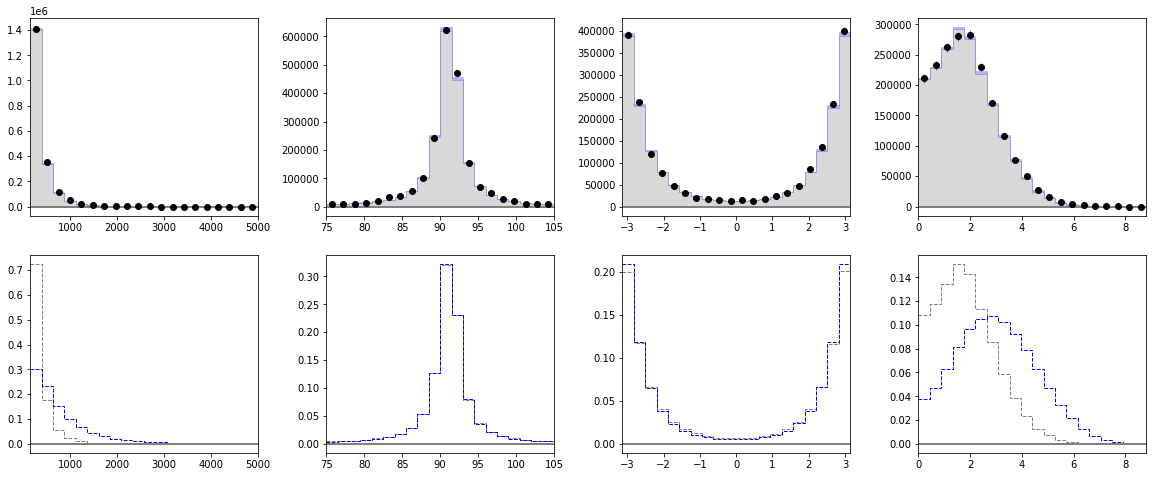

In [47]:
#  Plot Asimov in total fiducial phase space

fig = plt.figure(figsize=(5*num_observables, 8))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(2, num_observables, 1+idx)
    observables_QCD, weights_QCD = data_table_QCD.get_observables_and_weights()
    observables_EWK, weights_EWK = data_table_EWK.get_observables_and_weights()
    z_QCD , ez_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, normed=data_table_QCD.xsec_per_event*L, ebar=False, color="grey")
    z_EWK , ez_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, normed=data_table_EWK.xsec_per_event*L, ebar=False, color="blue", lower=z_QCD)
    z_data, ez_data = plot_observable_on_axis (ax, obs, fake_datapoints, fake_datapoint_weights, keys=data_table_EWK.keys, bins=20, normed=1., as_lines=False, ebar=True, color="black")
    
    ax = fig.add_subplot(2, num_observables, num_observables+1+idx)
    z_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, ebar=False, color="grey", fill=False)
    z_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, ebar=False, color="blue", fill=False)
plt.subplots_adjust(wspace=0.3)
plt.show()


filter efficiency is 3.06%  (13.8%)
filter efficiency is 3.06%  (13.8%)
filter efficiency is 3.06%  (13.8%)
filter efficiency is 3.06%  (13.8%)


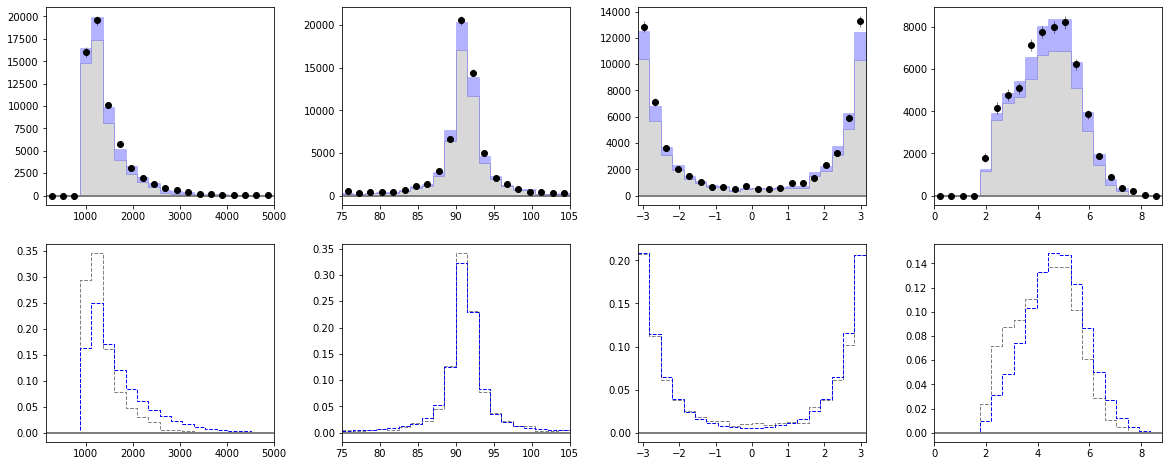

In [48]:
#  Plot Asimov in signal enhanced region

cuts = []
cuts.append(["m_jj"    , 1000, 5000])
cuts.append(["Dy_j_j"  , 2   , 8.8 ])

fig = plt.figure(figsize=(5*num_observables, 8))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(2, num_observables, 1+idx)
    observables_QCD, weights_QCD = data_table_QCD.get_observables_and_weights()
    observables_EWK, weights_EWK = data_table_EWK.get_observables_and_weights()
    z_QCD , ez_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, normed=data_table_QCD.xsec_per_event*L, ebar=False, color="grey", cuts=cuts)
    z_EWK , ez_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, normed=data_table_EWK.xsec_per_event*L, ebar=False, color="blue", lower=z_QCD, cuts=cuts)
    z_data, ez_data = plot_observable_on_axis (ax, obs, fake_datapoints, fake_datapoint_weights, keys=data_table_EWK.keys, bins=20, normed=1., as_lines=False, ebar=True, color="black", cuts=cuts, verbose=True)
    ax = fig.add_subplot(2, num_observables, num_observables+1+idx)
    plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, ebar=False, color="grey", fill=False, cuts=cuts)
    plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, ebar=False, color="blue", fill=False, cuts=cuts)
plt.subplots_adjust(wspace=0.3)
plt.show()


SM logL computed in 2.86s
theta = 0.1 logL computed in 2.97s


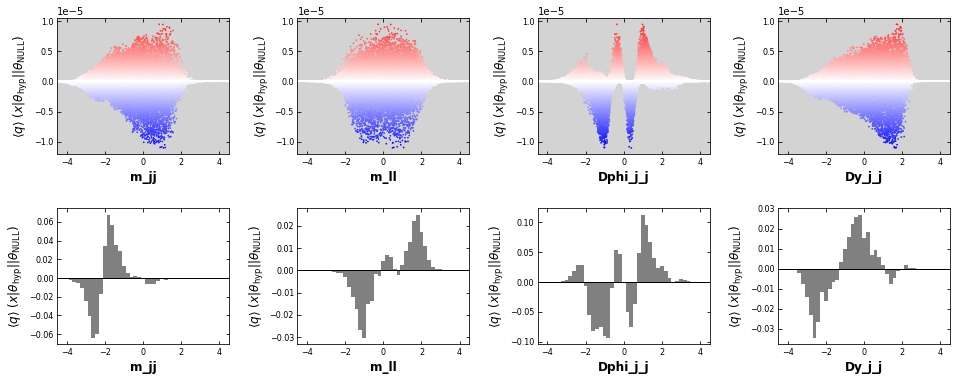

In [49]:

start       = time.time()
logL_NULL   = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
L_NULL      = np.exp(logL_NULL)
print(f"SM logL computed in {time.time()-start:.2f}s")

x, y = [], []
for theta in [0.1] :
    test_sig = np.full (fill_value=theta, shape=(len(fake_white_datapoints),))
    start    = time.time()
    logL     = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
    print(f"theta = {theta} logL computed in {time.time()-start:.2f}s")
    z        = -2 * L_NULL * (logL - logL_NULL)
    z_max    = np.max(np.fabs(z))
    
    fig = plt.figure(figsize=(4*num_observables, 6))
    for row_idx in range(num_observables) :
        x = fake_white_datapoints[:,row_idx]
        ax = fig.add_subplot(2, num_observables, row_idx + 1)
        ax.scatter(x, z, s=0.5, c=z, cmap="bwr", vmin=-z_max, vmax=z_max)
        ax.set_facecolor("lightgrey")
        ax.axhline(0, c="white", linewidth=2)
        ax.set_ylabel(r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=12, weight="bold")
        ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
        ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
        ax.set_xlim([-4.5, 4.5])
        x = fake_white_datapoints[:,row_idx]
        ax = fig.add_subplot(2, num_observables, num_observables + row_idx + 1)
        ax.hist(x, weights=fake_datapoint_weights*z, bins=np.linspace(-4.5, 4.5, 46), color="grey")
        ax.axhline(0, c="black", linewidth=1)
        ax.set_ylabel(r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=12, weight="bold")
        ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
        ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
        ax.set_xlim([-4.5, 4.5])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

theta = 0.1 logL computed in 2.91s


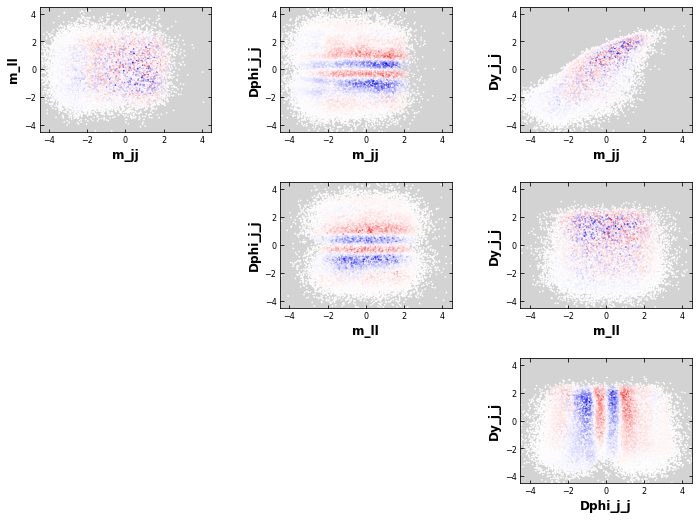

In [50]:

x, y = [], []
for theta in [0.1] :
    test_sig = np.full (fill_value=theta, shape=(len(fake_white_datapoints),))
    start    = time.time()
    logL     = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
    print(f"theta = {theta} logL computed in {time.time()-start:.2f}s")
    z        = -2 * L_NULL * (logL - logL_NULL)
    z_max    = np.max(np.fabs(z))
    
    fig = plt.figure(figsize=(4*num_observables, 3*num_observables))
    for row_idx in range(num_observables) :
        x = fake_white_datapoints[:,row_idx]
        for col_idx in range(row_idx+1, num_observables) :
            ax = fig.add_subplot(num_observables, num_observables, num_observables*row_idx + col_idx + 1)
            y = fake_white_datapoints[:,col_idx]
            ax.scatter(x, y, s=0.5, c=z, cmap="bwr", vmin=-z_max, vmax=z_max)
            ax.set_facecolor("lightgrey")
            ax.set_ylabel(observables_order[col_idx], fontsize=12, weight="bold")
            ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
            ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
            ax.set_xlim([-4.5, 4.5])
            ax.set_ylim([-4.5, 4.5])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

theta = 0.1 logL computed in 3.04s


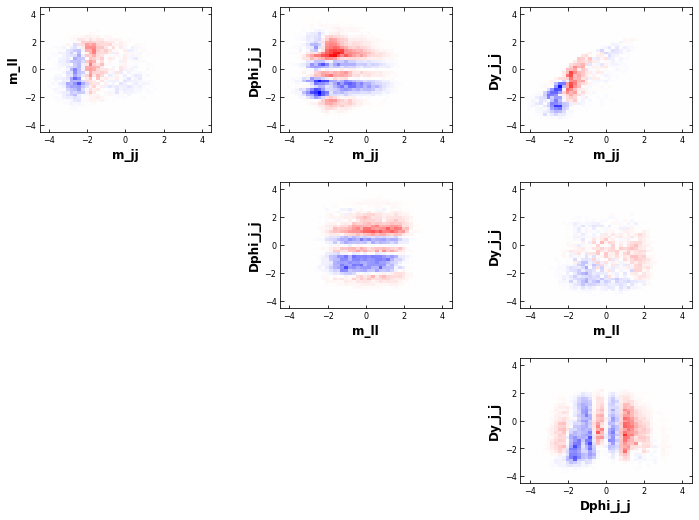

In [54]:

x, y = [], []
for theta in [0.1] :
    test_sig = np.full (fill_value=theta, shape=(len(fake_white_datapoints),))
    start    = time.time()
    logL     = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
    print(f"theta = {theta} logL computed in {time.time()-start:.2f}s")
    z        = -2 * L_NULL * (logL - logL_NULL)
    
    z_max = 0.
    for row_idx in range(num_observables) :
        x = fake_white_datapoints[:,row_idx]
        for col_idx in range(row_idx+1, num_observables) :
            y    = fake_white_datapoints[:,col_idx]
            bins = (np.linspace(-4.5, 4.5, 46), np.linspace(-4.5, 4.5, 46))
            h, _, _ = np.histogram2d(x, y, weights=fake_datapoint_weights*z, bins=bins)
            z_max = np.max([np.max(np.fabs(h)), z_max])
    
    fig = plt.figure(figsize=(4*num_observables, 3*num_observables))
    for row_idx in range(num_observables) :
        x = fake_white_datapoints[:,row_idx]
        for col_idx in range(row_idx+1, num_observables) :
            ax   = fig.add_subplot(num_observables, num_observables, num_observables*row_idx + col_idx + 1)
            y    = fake_white_datapoints[:,col_idx]
            bins = (np.linspace(-4.5, 4.5, 46), np.linspace(-4.5, 4.5, 46))
            ax.hist2d(x, y, weights=fake_datapoint_weights*z, bins=bins, cmap="bwr", vmin=-z_max, vmax=z_max)
            ax.set_facecolor("lightgrey")
            ax.set_ylabel(observables_order[col_idx], fontsize=12, weight="bold")
            ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=8)
            ax.set_xlabel(observables_order[row_idx], fontsize=12, weight="bold")
            ax.set_xlim([-4.5, 4.5])
            ax.set_ylim([-4.5, 4.5])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()


Creating new asimov for toy index 0
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 244s
QCD logL computed in 29.26s
EWK logL computed in 28.39s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

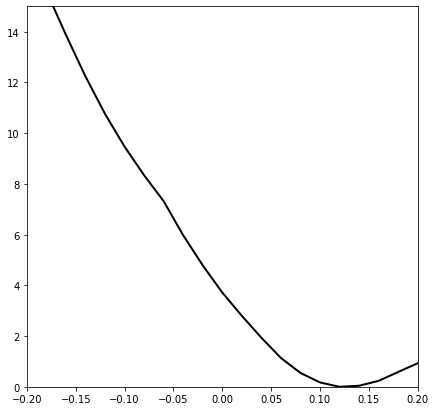


Creating new asimov for toy index 1
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 231s
QCD logL computed in 27.13s
EWK logL computed in 27.32s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

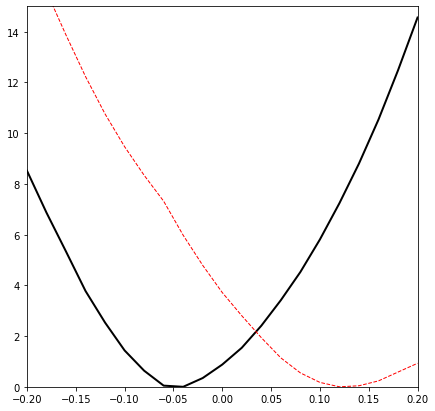


Creating new asimov for toy index 2
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 231s
QCD logL computed in 27.32s
EWK logL computed in 27.28s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

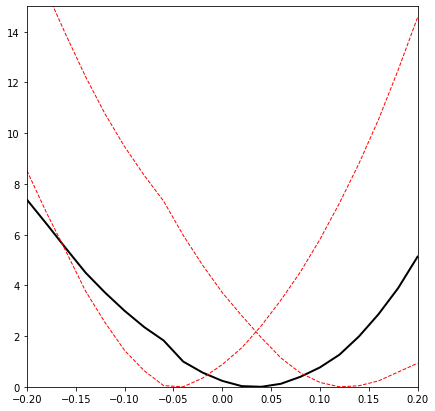


Creating new asimov for toy index 3
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 231s
QCD logL computed in 27.41s
EWK logL computed in 27.75s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

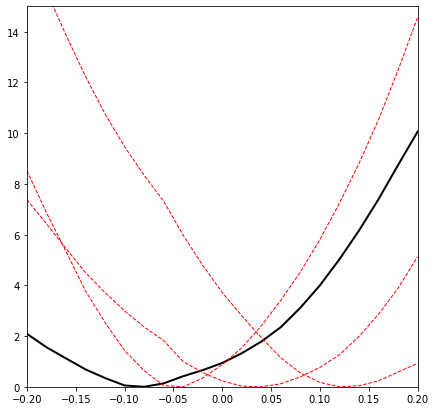


Creating new asimov for toy index 4
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 230s
QCD logL computed in 27.49s
EWK logL computed in 27.68s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

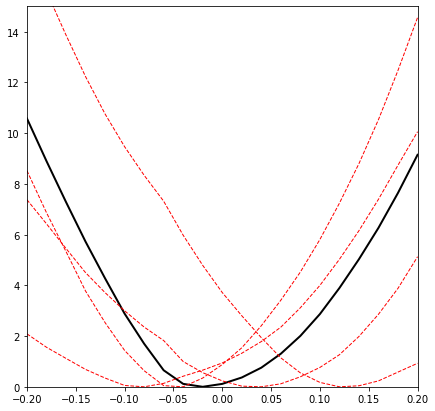

In [65]:

#  create several toy likelihood contour

num_toys = 5

profile_x  = np.linspace(-0.2, 0.2, 21)
profiles_y = []
for toy_idx in range(num_toys) :  
    print(f"\nCreating new asimov for toy index {toy_idx}")
    generate_asimov(500000, 0, 0)

    print(f"Doing scan for toy index {toy_idx}")
    yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0))
    TNLL_NULL = np.sum(np.longdouble(fake_datapoint_weights)*yp_NULL)

    profile_y = []
    for x in profile_x :
        sys.stdout.write(f"\nx = {x:.3f}")
        test_sig = np.ones (shape=(len(fake_white_datapoints),)) * x
        yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))
        TNLL = -2 * (np.sum(np.longdouble(fake_datapoint_weights)*(yp-yp_NULL))) # + TNLL_NULL)
        sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
        profile_y.append(TNLL)
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(1, 1, 1)
    ax.plot(profile_x, profile_y-np.min(profile_y), "-", linewidth=2, c="k")
    for other_y in profiles_y :
        ax.plot(profile_x, other_y-np.min(other_y), "--", linewidth=1, c="r")
    ax.set_ylim([0, 15])
    ax.set_xlim(profile_x[0], profile_x[-1])
    plt.show()
    profiles_y.append(profile_y)


Creating new asimov for toy index 0
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 231s
QCD logL computed in 29.12s
EWK logL computed in 27.61s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

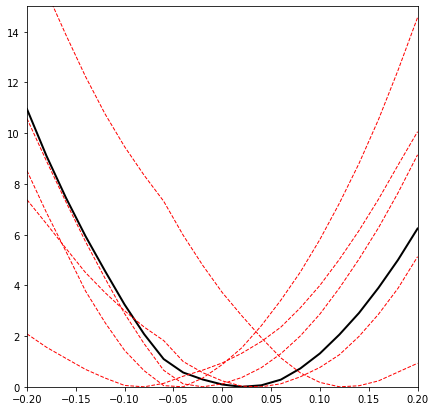


Creating new asimov for toy index 1
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 231s
QCD logL computed in 27.16s
EWK logL computed in 27.29s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 

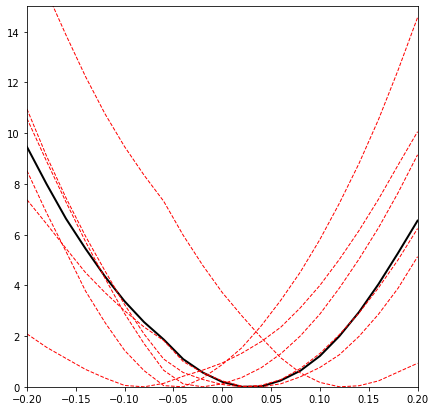


Creating new asimov for toy index 2
Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 239s
QCD logL computed in 28.02s


KeyboardInterrupt: 

In [66]:

#  create several toy likelihood contour

for toy_idx in range(num_toys) :  
    print(f"\nCreating new asimov for toy index {toy_idx}")
    generate_asimov(500000, 0, 0)

    print(f"Doing scan for toy index {toy_idx}")
    dummy_zeros = np.zeros(len(fake_white_datapoints))
    yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0))
    TNLL_NULL = np.sum(np.longdouble(fake_datapoint_weights)*yp_NULL)

    profile_y = []
    for x in profile_x :
        sys.stdout.write(f"\nx = {x:.3f}")
        test_sig = np.ones (shape=(len(fake_white_datapoints),)) * x
        yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))
        TNLL = -2 * (np.sum(np.longdouble(fake_datapoint_weights)*(yp-yp_NULL))) # + TNLL_NULL)
        sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
        profile_y.append(TNLL)
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(1, 1, 1)
    ax.plot(profile_x, profile_y-np.min(profile_y), "-", linewidth=2, c="k")
    for other_y in profiles_y :
        ax.plot(profile_x, other_y-np.min(other_y), "--", linewidth=1, c="r")
    ax.set_ylim([0, 15])
    ax.set_xlim(profile_x[0], profile_x[-1])
    plt.show()
    profiles_y.append(profile_y)

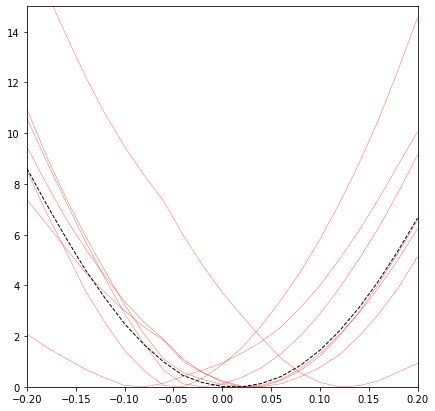

In [70]:

fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(1, 1, 1)
for profile_y in profiles_y :
    ax.plot(profile_x, profile_y-np.min(profile_y), "-", linewidth=0.3, c="r")

av_y = []
for i in range(len(profile_x)) :
    av_y.append(np.mean([y[i]-np.min(y) for y in profiles_y]))
ax.plot(profile_x, av_y - np.min(av_y), "--", linewidth=1, c="k")
    
ax.set_ylim([0, 15])
ax.set_xlim(profile_x[0], profile_x[-1])
plt.show()

In [109]:

generate_asimov(500000, 0, 0) 

yp_NULL  = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
test_sig = np.ones (shape=(len(fake_white_datapoints),)) * 0.1
yp       = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
DLL      = fake_datapoint_weights * np.fabs(yp-yp_NULL)

data_to_fit    = {0: fake_white_datapoints}
weights_to_fit = {0: DLL                  }

Generating 500000 fake datapoints
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 0 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 254s
QCD logL computed in 34.46s
EWK logL computed in 34.42s
Importance sampling with EWK fraction 0
- no QCD events generated, so setting EWK fraction to 1
sigma_gen_EWK = 3.571
sigma_gen_QCD = 0.000
sigma_EWK     = 0.290
sigma_QCD

In [110]:

density_model_TNLL = DensityModel(name            = "asimov_sampling_model", 
                                  num_gaussians   = 15, 
                                  num_conditions  = 1, 
                                  num_observables = data_table_EWK.get_num_observables(), 
                                  types           = data_table_EWK.types,
                                  int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data_table_EWK.keys, data_table_EWK.types)) if t == int},
                                  verbose         = True,
                                  learning_rate   = 0.001,
                                  optimiser       = "adam")

density_model_TNLL.fit(data_to_fit, 
                      weights_to_fit,
                      observable                = [0, 1, 2, 3],
                      max_epochs_per_observable = 100,
                      early_stopping_patience   = 5,
                      early_stopping_min_delta  = 0,
                      validation_split          = 0.5,
                      batch_size_per_observable = 100)
    

INFO       DensityModel.construct      Set model name           : asimov_sampling_model
INFO       DensityModel.construct      Set model num_gaussians  : 15
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 4
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.build          Building model segment: asimov_sampling_model_observable0 for observable index 0
Creating continuous density model: asimov_sampling_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 15
  - range              is -5.0000 - 5.0000
Model: "asimov_sampling_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (Inpu

Model: "asimov_sampling_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
dense_371 (Dense)               (None, 7)            14          input_83[0][0]                   
__________________________________________________________________________________________________
dense_372 (Dense)               (None, 6)            18          input_84[0][0]                   
__________________________________________________________________

INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 100
INFO       DensityModel.fit              -  Training setting: batch_size = 100
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 250000 samples, validate on 250000 samples
Epoch 1/100
250000/250000 [==============================] - 19s 77us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 2/100
250000/250000 [==============================] - 15s 60us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/100
250000/250000 [==============================] - 15s 61us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/100
250000/250000 [==============================] - 16s 62us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
250000/250000

250000/250000 [==============================] - 17s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 15/100
250000/250000 [==============================] - 17s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 16/100
250000/250000 [==============================] - 17s 67us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 17/100
250000/250000 [==============================] - 17s 69us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 18/100
250000/250000 [==============================] - 17s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 19/100
250000/250000 [==============================] - 17s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 20/100
250000/250000 [==============================] - 17s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 21/100
250000/250000 [==============================] - 16s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 22/100
250000/250000 [==============================] - 16s 66us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 23/100
250000/250

In [144]:
probe_ds = density_model_TNLL.sample(500000, [0])

INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3


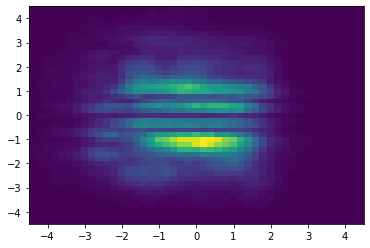

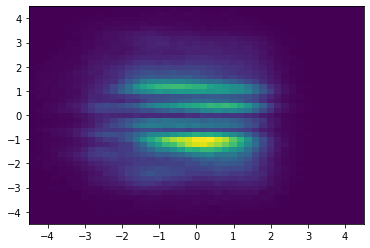

In [145]:
plt.hist2d(fake_white_datapoints[:,0], fake_white_datapoints[:,2], weights=DLL, bins=np.linspace(-4.5, 4.5, 46))
plt.show()

plt.hist2d(probe_ds[:,0], probe_ds[:,2], bins=np.linspace(-4.5, 4.5, 46))
plt.show()

In [146]:
probe_pdf = density_model_TNLL.evaluate(0, probe_ds)

In [147]:
dummy_zeros_probe = np.zeros(shape=len(probe_ds))

QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
EWK_logL_probe = EWK_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)

QCD_L_probe = np.exp(QCD_logL_probe)
EWK_L_probe = np.exp(EWK_logL_probe)

In [148]:

reweight_pdf  = (sigma_EWK*EWK_L_probe + sigma_QCD*QCD_L_probe) / sigma_tot
probe_weights = L * sigma_tot * reweight_pdf / (probe_pdf * len(probe_ds))

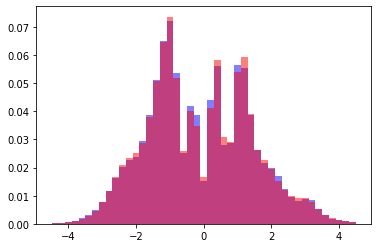

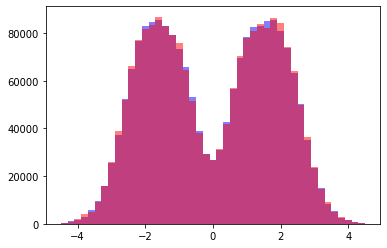

In [149]:
plt.hist(fake_white_datapoints[:,2], weights=DLL/np.sum(DLL), bins=np.linspace(-4.5, 4.5, 46), alpha=0.5, color="b")
plt.hist(probe_ds[:,2], weights=[1/len(probe_ds) for i in range(len(probe_ds))], bins=np.linspace(-4.5, 4.5, 46), alpha=0.5, color="r")
plt.show()

plt.hist(fake_white_datapoints[:,2], weights=fake_datapoint_weights, bins=np.linspace(-4.5, 4.5, 46), alpha=0.5, color="b")
plt.hist(probe_ds[:,2], weights=probe_weights, bins=np.linspace(-4.5, 4.5, 46), alpha=0.5, color="r")
plt.show()

In [150]:

yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, probe_ds], verbose=0))
TNLL_NULL = np.sum(np.longdouble(probe_weights)*yp_NULL)

profile_y = []
for x in profile_x :
    sys.stdout.write(f"\nx = {x:.3f}")
    test_sig = np.ones (shape=(len(probe_ds),)) * x
    yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, probe_ds], verbose=0))
    TNLL = -2 * (np.sum(np.longdouble(probe_weights)*(yp-yp_NULL))) # + TNLL_NULL)
    sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
    profile_y.append(TNLL)


x = -0.200  y = 7.328
x = -0.180  y = 5.719
x = -0.160  y = 4.264
x = -0.140  y = 2.924
x = -0.120  y = 1.705
x = -0.100  y = 0.712
x = -0.080  y = 0.154
x = -0.060  y = -0.216
x = -0.040  y = -0.271
x = -0.020  y = -0.195
x = 0.000  y = -0.000
x = 0.020  y = 0.436
x = 0.040  y = 1.069
x = 0.060  y = 1.848
x = 0.080  y = 2.795
x = 0.100  y = 3.918
x = 0.120  y = 5.169
x = 0.140  y = 6.416
x = 0.160  y = 7.713
x = 0.180  y = 9.074
x = 0.200  y = 10.468

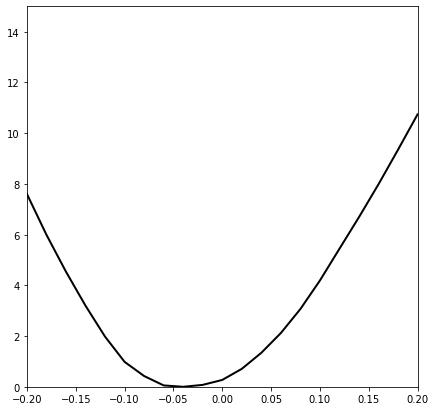

In [151]:

fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(profile_x, profile_y-np.min(profile_y), "-", linewidth=2, c="k")
ax.set_ylim([0, 15])
ax.set_xlim(profile_x[0], profile_x[-1])
plt.show()


Creating new asimov for toy index 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 0

x = -0.200  y = 2.248
x = -0.180  y = 1.511
x = -0.160  y = 0.875
x = -0.140  y = 0.177
x = -0.120  y = -0.299
x = -0.100  y = -0.511
x = -0.080  y = -0.500
x = -0.060  y = -0.402
x = -0.040  y = -0.427
x = -0.020  y = -0.330
x = 0.000  y = -0.000
x = 0.020  y = 0.503
x = 0.040  y = 1.110
x = 0.060  y = 1.842
x = 0.080  y = 2.728
x = 0.100  y = 3.718
x = 0.120  y = 4.871
x = 0.140  y = 6.199
x = 0.160  y = 7.704
x = 0.180  y = 9.402
x = 0.200  y = 11.189

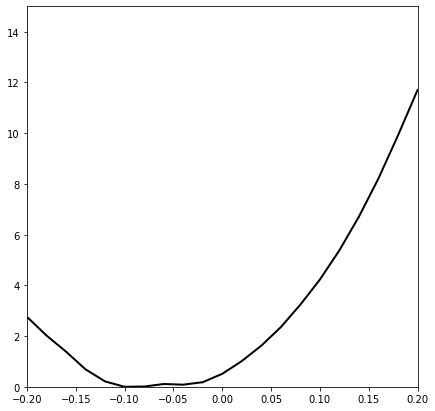


Creating new asimov for toy index 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 1

x = -0.200  y = 5.005
x = -0.180  y = 3.987
x = -0.160  y = 3.071
x = -0.140  y = 2.280
x = -0.120  y = 1.641
x = -0.100  y = 1.113
x = -0.080  y = 0.829
x = -0.060  y = 0.751
x = -0.040  y = 0.397
x = -0.020  y = 0.164
x = 0.000  y = -0.000
x = 0.020  y = -0.000
x = 0.040  y = 0.203
x = 0.060  y = 0.623
x = 0.080  y = 1.299
x = 0.100  y = 2.115
x = 0.120  y = 3.034
x = 0.140  y = 4.026
x = 0.160  y = 5.154
x = 0.180  y = 6.424
x = 0.200  y = 7.822

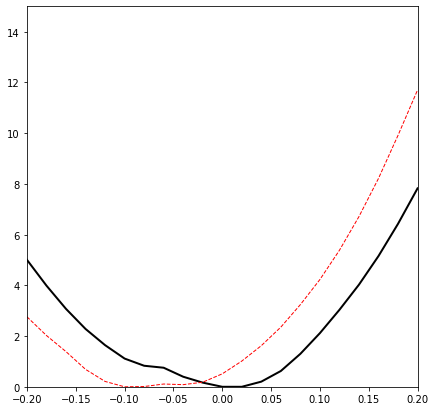


Creating new asimov for toy index 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 2

x = -0.200  y = 9.553
x = -0.180  y = 8.073
x = -0.160  y = 6.782
x = -0.140  y = 5.621
x = -0.120  y = 4.572
x = -0.100  y = 3.491
x = -0.080  y = 2.521
x = -0.060  y = 1.768
x = -0.040  y = 1.095
x = -0.020  y = 0.478
x = 0.000  y = -0.000
x = 0.020  y = -0.328
x = 0.040  y = -0.549
x = 0.060  y = -0.543
x = 0.080  y = -0.243
x = 0.100  y = 0.245
x = 0.120  y = 0.840
x = 0.140  y = 1.624
x = 0.160  y = 2.554
x = 0.180  y = 3.629
x = 0.200  y = 4.916

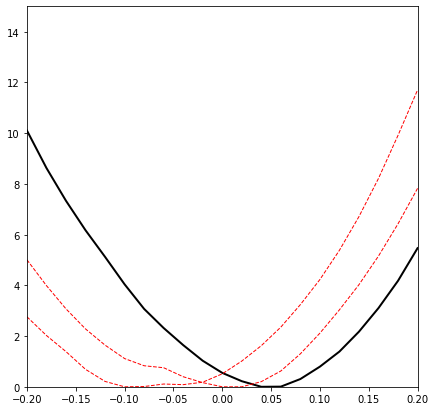


Creating new asimov for toy index 3
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 3

x = -0.200  y = 10.070
x = -0.180  y = 8.409
x = -0.160  y = 6.912
x = -0.140  y = 5.472
x = -0.120  y = 4.215
x = -0.100  y = 3.205
x = -0.080  y = 2.325
x = -0.060  y = 1.599
x = -0.040  y = 0.763
x = -0.020  y = 0.265
x = 0.000  y = -0.000
x = 0.020  y = -0.139
x = 0.040  y = -0.144
x = 0.060  y = -0.132
x = 0.080  y = -0.098
x = 0.100  y = 0.060
x = 0.120  y = 0.324
x = 0.140  y = 0.753
x = 0.160  y = 1.278
x = 0.180  y = 1.968
x = 0.200  y = 2.667

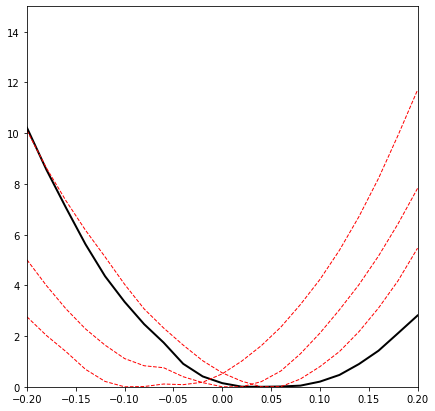


Creating new asimov for toy index 4
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 4

x = -0.200  y = 13.933
x = -0.180  y = 11.869
x = -0.160  y = 9.982
x = -0.140  y = 8.291
x = -0.120  y = 6.678
x = -0.100  y = 5.110
x = -0.080  y = 3.635
x = -0.060  y = 2.247
x = -0.040  y = 1.028
x = -0.020  y = 0.360
x = 0.000  y = -0.000
x = 0.020  y = -0.201
x = 0.040  y = -0.300
x = 0.060  y = -0.279
x = 0.080  y = -0.142
x = 0.100  y = 0.104
x = 0.120  y = 0.555
x = 0.140  y = 1.139
x = 0.160  y = 1.835
x = 0.180  y = 2.660
x = 0.200  y = 3.675

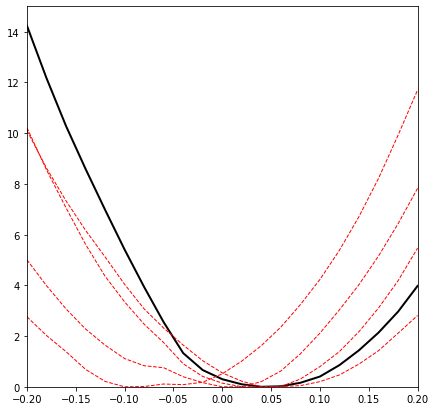


Creating new asimov for toy index 5
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 5

x = -0.200  y = 6.611
x = -0.180  y = 5.085
x = -0.160  y = 3.730
x = -0.140  y = 2.577
x = -0.120  y = 1.641
x = -0.100  y = 0.855
x = -0.080  y = 0.159
x = -0.060  y = -0.351
x = -0.040  y = -0.434
x = -0.020  y = -0.283
x = 0.000  y = -0.000
x = 0.020  y = 0.450
x = 0.040  y = 1.030
x = 0.060  y = 1.839
x = 0.080  y = 2.863
x = 0.100  y = 3.994
x = 0.120  y = 5.269
x = 0.140  y = 6.698
x = 0.160  y = 8.158
x = 0.180  y = 9.712
x = 0.200  y = 11.285

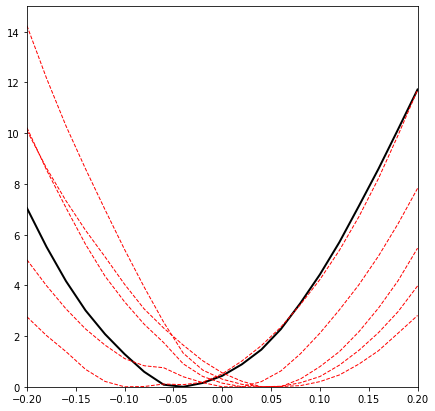


Creating new asimov for toy index 6
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 6

x = -0.200  y = 15.074
x = -0.180  y = 12.404
x = -0.160  y = 10.010
x = -0.140  y = 7.868
x = -0.120  y = 6.003
x = -0.100  y = 4.203
x = -0.080  y = 2.459
x = -0.060  y = 1.016
x = -0.040  y = 0.356
x = -0.020  y = 0.056
x = 0.000  y = -0.000
x = 0.020  y = 0.141
x = 0.040  y = 0.507
x = 0.060  y = 1.123
x = 0.080  y = 1.946
x = 0.100  y = 2.916
x = 0.120  y = 4.005
x = 0.140  y = 5.242
x = 0.160  y = 6.632
x = 0.180  y = 8.187
x = 0.200  y = 9.912

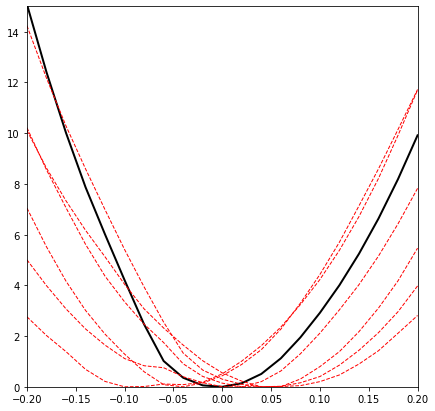


Creating new asimov for toy index 7
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 7

x = -0.200  y = 2.208
x = -0.180  y = 1.413
x = -0.160  y = 0.875
x = -0.140  y = 0.493
x = -0.120  y = 0.268
x = -0.100  y = 0.214
x = -0.080  y = 0.293
x = -0.060  y = 0.558
x = -0.040  y = 0.226
x = -0.020  y = 0.043
x = 0.000  y = -0.000
x = 0.020  y = 0.129
x = 0.040  y = 0.499
x = 0.060  y = 1.030
x = 0.080  y = 1.767
x = 0.100  y = 2.632
x = 0.120  y = 3.722
x = 0.140  y = 4.974
x = 0.160  y = 6.359
x = 0.180  y = 7.904
x = 0.200  y = 9.577

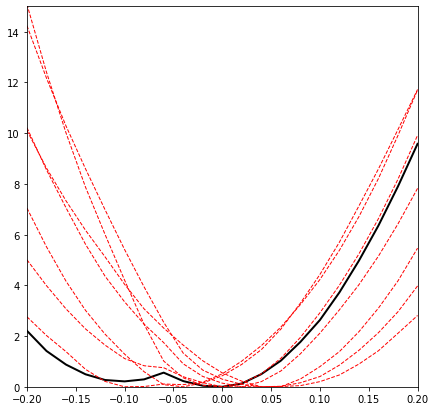


Creating new asimov for toy index 8
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 8

x = -0.200  y = 6.148
x = -0.180  y = 4.666
x = -0.160  y = 3.440
x = -0.140  y = 2.163
x = -0.120  y = 1.270
x = -0.100  y = 0.637
x = -0.080  y = 0.290
x = -0.060  y = 0.055
x = -0.040  y = -0.035
x = -0.020  y = -0.058
x = 0.000  y = -0.000
x = 0.020  y = 0.319
x = 0.040  y = 0.848
x = 0.060  y = 1.512
x = 0.080  y = 2.373
x = 0.100  y = 3.380
x = 0.120  y = 4.687
x = 0.140  y = 6.166
x = 0.160  y = 7.757
x = 0.180  y = 9.519
x = 0.200  y = 11.375

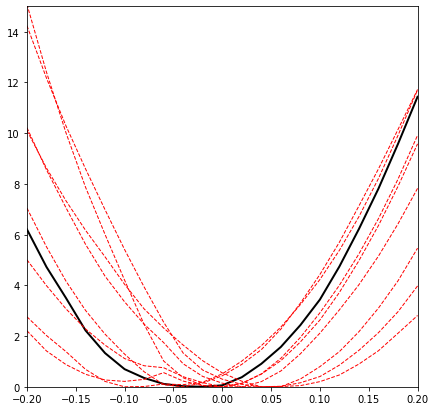


Creating new asimov for toy index 9
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 9

x = -0.200  y = 5.771
x = -0.180  y = 4.728
x = -0.160  y = 3.818
x = -0.140  y = 3.058
x = -0.120  y = 2.456
x = -0.100  y = 1.929
x = -0.080  y = 1.676
x = -0.060  y = 1.644
x = -0.040  y = 1.083
x = -0.020  y = 0.488
x = 0.000  y = -0.000
x = 0.020  y = -0.320
x = 0.040  y = -0.449
x = 0.060  y = -0.422
x = 0.080  y = -0.272
x = 0.100  y = 0.073
x = 0.120  y = 0.556
x = 0.140  y = 1.130
x = 0.160  y = 1.791
x = 0.180  y = 2.647
x = 0.200  y = 3.684

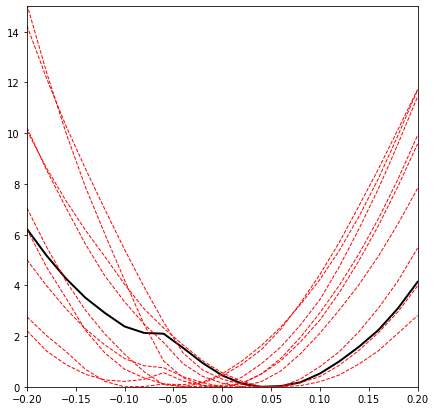


Creating new asimov for toy index 10
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 10

x = -0.200  y = 5.155
x = -0.180  y = 3.978
x = -0.160  y = 3.024
x = -0.140  y = 2.300
x = -0.120  y = 1.807
x = -0.100  y = 1.449
x = -0.080  y = 1.082
x = -0.060  y = 0.794
x = -0.040  y = 0.334
x = -0.020  y = 0.025
x = 0.000  y = -0.000
x = 0.020  y = 0.096
x = 0.040  y = 0.303
x = 0.060  y = 0.618
x = 0.080  y = 1.093
x = 0.100  y = 1.729
x = 0.120  y = 2.567
x = 0.140  y = 3.648
x = 0.160  y = 4.834
x = 0.180  y = 6.114
x = 0.200  y = 7.654

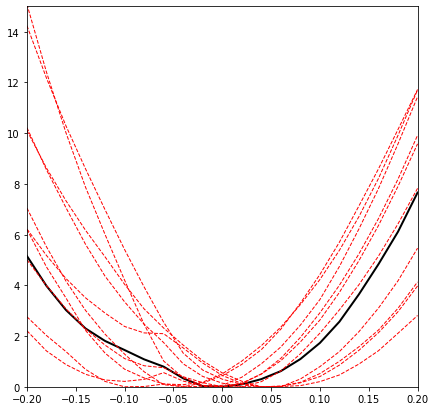


Creating new asimov for toy index 11
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 11

x = -0.200  y = 9.061
x = -0.180  y = 7.277
x = -0.160  y = 5.684
x = -0.140  y = 4.157
x = -0.120  y = 2.864
x = -0.100  y = 1.692
x = -0.080  y = 0.734
x = -0.060  y = -0.006
x = -0.040  y = -0.148
x = -0.020  y = -0.157
x = 0.000  y = -0.000
x = 0.020  y = 0.452
x = 0.040  y = 1.070
x = 0.060  y = 1.800
x = 0.080  y = 2.653
x = 0.100  y = 3.620
x = 0.120  y = 4.658
x = 0.140  y = 5.820
x = 0.160  y = 7.110
x = 0.180  y = 8.521
x = 0.200  y = 9.969

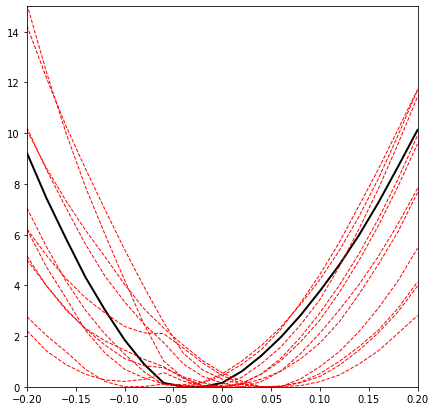


Creating new asimov for toy index 12
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 12

x = -0.200  y = 12.971
x = -0.180  y = 10.980
x = -0.160  y = 9.027
x = -0.140  y = 7.183
x = -0.120  y = 5.569
x = -0.100  y = 4.032
x = -0.080  y = 2.706
x = -0.060  y = 1.641
x = -0.040  y = 0.897
x = -0.020  y = 0.322
x = 0.000  y = -0.000
x = 0.020  y = -0.123
x = 0.040  y = -0.069
x = 0.060  y = 0.166
x = 0.080  y = 0.581
x = 0.100  y = 1.143
x = 0.120  y = 1.872
x = 0.140  y = 2.725
x = 0.160  y = 3.724
x = 0.180  y = 4.808
x = 0.200  y = 6.046

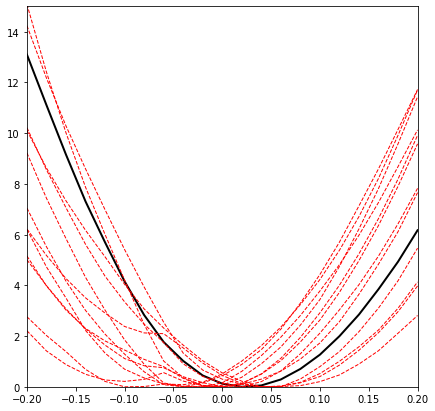


Creating new asimov for toy index 13
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 13

x = -0.200  y = -0.052
x = -0.180  y = -0.787
x = -0.160  y = -1.406
x = -0.140  y = -1.789
x = -0.120  y = -2.025
x = -0.100  y = -2.004
x = -0.080  y = -1.676
x = -0.060  y = -1.091
x = -0.040  y = -0.789
x = -0.020  y = -0.539
x = 0.000  y = -0.000
x = 0.020  y = 0.660
x = 0.040  y = 1.442
x = 0.060  y = 2.416
x = 0.080  y = 3.638
x = 0.100  y = 4.947
x = 0.120  y = 6.304
x = 0.140  y = 7.726
x = 0.160  y = 9.305
x = 0.180  y = 10.999
x = 0.200  y = 12.625

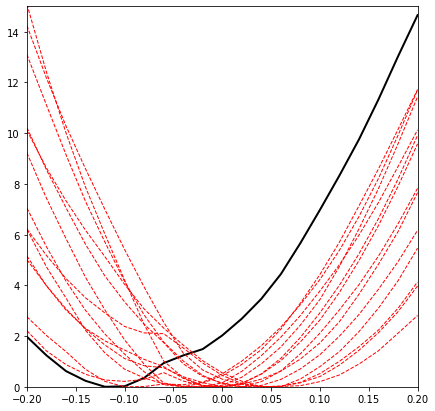


Creating new asimov for toy index 14
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 14

x = -0.200  y = 14.694
x = -0.180  y = 12.142
x = -0.160  y = 9.770
x = -0.140  y = 7.616
x = -0.120  y = 5.692
x = -0.100  y = 3.934
x = -0.080  y = 2.539
x = -0.060  y = 1.351
x = -0.040  y = 0.792
x = -0.020  y = 0.306
x = 0.000  y = -0.000
x = 0.020  y = -0.123
x = 0.040  y = -0.167
x = 0.060  y = -0.047
x = 0.080  y = 0.194
x = 0.100  y = 0.529
x = 0.120  y = 1.024
x = 0.140  y = 1.654
x = 0.160  y = 2.472
x = 0.180  y = 3.434
x = 0.200  y = 4.612

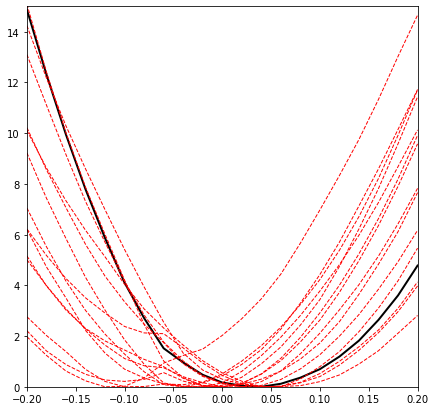


Creating new asimov for toy index 15
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 15

x = -0.200  y = 14.420
x = -0.180  y = 12.759
x = -0.160  y = 11.221
x = -0.140  y = 9.636
x = -0.120  y = 8.027
x = -0.100  y = 6.492
x = -0.080  y = 5.065
x = -0.060  y = 3.785
x = -0.040  y = 2.008
x = -0.020  y = 0.855
x = 0.000  y = -0.000
x = 0.020  y = -0.685
x = 0.040  y = -1.213
x = 0.060  y = -1.574
x = 0.080  y = -1.779
x = 0.100  y = -1.891
x = 0.120  y = -1.817
x = 0.140  y = -1.488
x = 0.160  y = -0.998
x = 0.180  y = -0.325
x = 0.200  y = 0.534

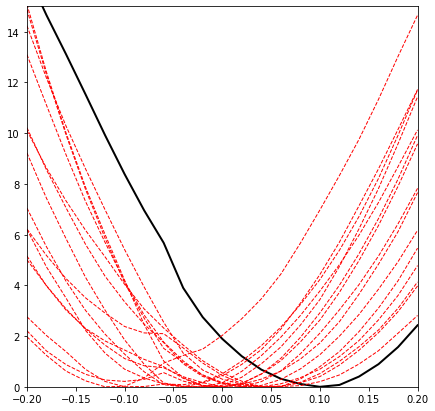


Creating new asimov for toy index 16
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 16

x = -0.200  y = 8.490
x = -0.180  y = 7.219
x = -0.160  y = 6.079
x = -0.140  y = 4.859
x = -0.120  y = 3.691
x = -0.100  y = 2.590
x = -0.080  y = 1.716
x = -0.060  y = 0.935
x = -0.040  y = 0.222
x = -0.020  y = -0.010
x = 0.000  y = -0.000
x = 0.020  y = 0.219
x = 0.040  y = 0.569
x = 0.060  y = 1.084
x = 0.080  y = 1.798
x = 0.100  y = 2.698
x = 0.120  y = 3.703
x = 0.140  y = 4.771
x = 0.160  y = 5.929
x = 0.180  y = 7.107
x = 0.200  y = 8.412

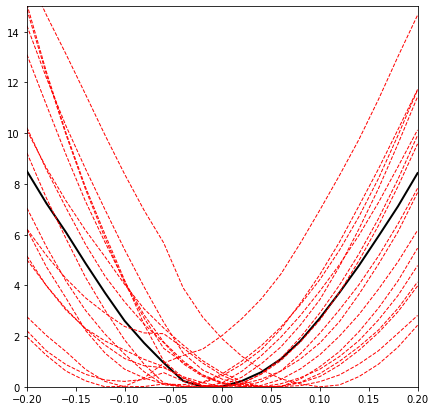


Creating new asimov for toy index 17
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 17

x = -0.200  y = 7.108
x = -0.180  y = 5.901
x = -0.160  y = 4.718
x = -0.140  y = 3.479
x = -0.120  y = 2.446
x = -0.100  y = 1.634
x = -0.080  y = 1.103
x = -0.060  y = 0.742
x = -0.040  y = 0.407
x = -0.020  y = 0.149
x = 0.000  y = -0.000
x = 0.020  y = -0.016
x = 0.040  y = 0.053
x = 0.060  y = 0.342
x = 0.080  y = 0.819
x = 0.100  y = 1.484
x = 0.120  y = 2.280
x = 0.140  y = 3.271
x = 0.160  y = 4.432
x = 0.180  y = 5.695
x = 0.200  y = 7.114

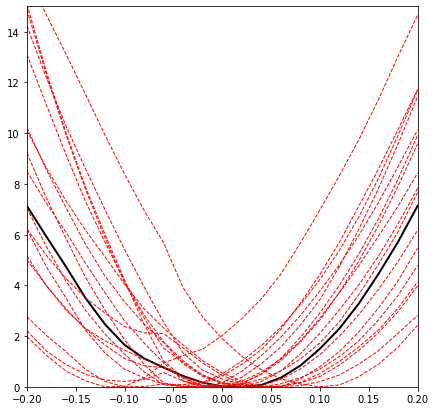


Creating new asimov for toy index 18
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 18

x = -0.200  y = -1.188
x = -0.180  y = -1.597
x = -0.160  y = -1.841
x = -0.140  y = -1.967
x = -0.120  y = -2.092
x = -0.100  y = -2.199
x = -0.080  y = -2.189
x = -0.060  y = -2.017
x = -0.040  y = -1.474
x = -0.020  y = -0.825
x = 0.000  y = -0.000
x = 0.020  y = 0.956
x = 0.040  y = 1.989
x = 0.060  y = 3.157
x = 0.080  y = 4.476
x = 0.100  y = 5.869
x = 0.120  y = 7.348
x = 0.140  y = 8.901
x = 0.160  y = 10.569
x = 0.180  y = 12.392
x = 0.200  y = 14.287

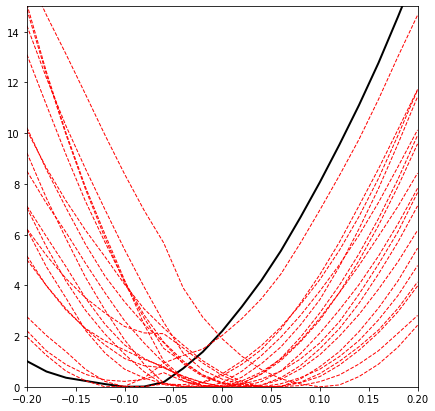


Creating new asimov for toy index 19
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 19

x = -0.200  y = 8.753
x = -0.180  y = 7.105
x = -0.160  y = 5.616
x = -0.140  y = 4.237
x = -0.120  y = 3.036
x = -0.100  y = 1.941
x = -0.080  y = 0.986
x = -0.060  y = 0.148
x = -0.040  y = -0.143
x = -0.020  y = -0.165
x = 0.000  y = -0.000
x = 0.020  y = 0.444
x = 0.040  y = 1.087
x = 0.060  y = 1.917
x = 0.080  y = 2.909
x = 0.100  y = 4.002
x = 0.120  y = 5.280
x = 0.140  y = 6.764
x = 0.160  y = 8.359
x = 0.180  y = 10.146
x = 0.200  y = 12.091

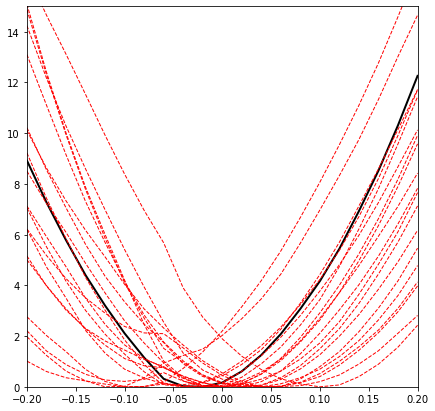


Creating new asimov for toy index 20
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 20

x = -0.200  y = 5.593
x = -0.180  y = 3.869
x = -0.160  y = 2.422
x = -0.140  y = 1.220
x = -0.120  y = 0.397
x = -0.100  y = -0.182
x = -0.080  y = -0.696
x = -0.060  y = -1.174
x = -0.040  y = -1.073
x = -0.020  y = -0.591
x = 0.000  y = -0.000
x = 0.020  y = 0.721
x = 0.040  y = 1.591
x = 0.060  y = 2.622
x = 0.080  y = 3.858
x = 0.100  y = 5.248
x = 0.120  y = 6.861
x = 0.140  y = 8.593
x = 0.160  y = 10.476
x = 0.180  y = 12.507
x = 0.200  y = 14.708

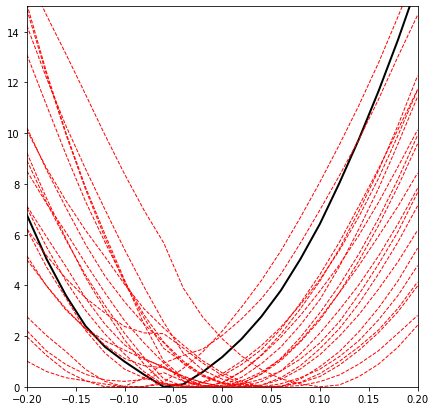


Creating new asimov for toy index 21
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 21

x = -0.200  y = 9.553
x = -0.180  y = 7.573
x = -0.160  y = 5.850
x = -0.140  y = 4.428
x = -0.120  y = 3.174
x = -0.100  y = 2.001
x = -0.080  y = 0.989
x = -0.060  y = 0.135
x = -0.040  y = -0.265
x = -0.020  y = -0.225
x = 0.000  y = -0.000
x = 0.020  y = 0.364
x = 0.040  y = 0.893
x = 0.060  y = 1.563
x = 0.080  y = 2.447
x = 0.100  y = 3.368
x = 0.120  y = 4.413
x = 0.140  y = 5.512
x = 0.160  y = 6.666
x = 0.180  y = 8.002
x = 0.200  y = 9.357

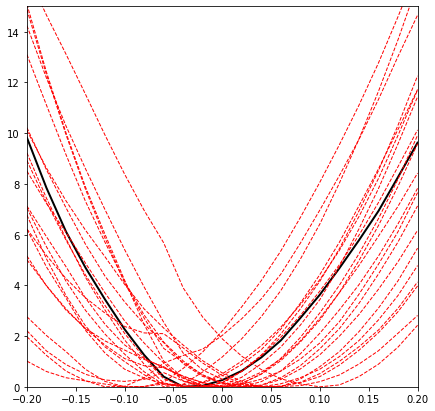


Creating new asimov for toy index 22
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 22

x = -0.200  y = -0.518
x = -0.180  y = -1.416
x = -0.160  y = -2.047
x = -0.140  y = -2.497
x = -0.120  y = -2.632
x = -0.100  y = -2.409
x = -0.080  y = -2.019
x = -0.060  y = -1.474
x = -0.040  y = -1.144
x = -0.020  y = -0.642
x = 0.000  y = -0.000
x = 0.020  y = 0.787
x = 0.040  y = 1.633
x = 0.060  y = 2.565
x = 0.080  y = 3.649
x = 0.100  y = 4.919
x = 0.120  y = 6.418
x = 0.140  y = 8.096
x = 0.160  y = 9.884
x = 0.180  y = 11.928
x = 0.200  y = 14.210

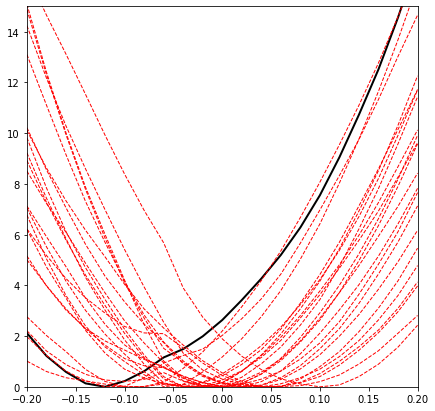


Creating new asimov for toy index 23
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
Doing scan for toy index 23

x = -0.200  y = 13.129
x = -0.180  y = 10.817
x = -0.160  y = 8.632
x = -0.140  y = 6.573
x = -0.120

KeyboardInterrupt: 

In [152]:
profiles_y_new = []
for toy_idx in range(1000) :  
    print(f"\nCreating new asimov for toy index {toy_idx}")
    probe_ds  = density_model_TNLL.sample(500000, [0])
    probe_pdf = density_model_TNLL.evaluate(0, probe_ds)
    QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
    EWK_logL_probe = EWK_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
    QCD_L_probe = np.exp(QCD_logL_probe)
    EWK_L_probe = np.exp(EWK_logL_probe)
    reweight_pdf  = (sigma_EWK*EWK_L_probe + sigma_QCD*QCD_L_probe) / sigma_tot
    probe_weights = L * sigma_tot * reweight_pdf / (probe_pdf * len(probe_ds))

    print(f"Doing scan for toy index {toy_idx}")
    yp_NULL   = np.longdouble(EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, probe_ds], verbose=0))
    TNLL_NULL = np.sum(np.longdouble(probe_weights)*yp_NULL)

    profile_y = []
    for x in profile_x :
        sys.stdout.write(f"\nx = {x:.3f}")
        test_sig = np.ones (shape=(len(probe_ds),)) * x
        yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, probe_ds], verbose=0))
        TNLL = -2 * (np.sum(np.longdouble(probe_weights)*(yp-yp_NULL)))
        sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
        profile_y.append(TNLL)
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(1, 1, 1)
    ax.plot(profile_x, profile_y-np.min(profile_y), "-", linewidth=2, c="k")
    for other_y in profiles_y_new :
        ax.plot(profile_x, other_y-np.min(other_y), "--", linewidth=1, c="r")
    ax.set_ylim([0, 15])
    ax.set_xlim(profile_x[0], profile_x[-1])
    plt.show()
    profiles_y_new.append(profile_y)

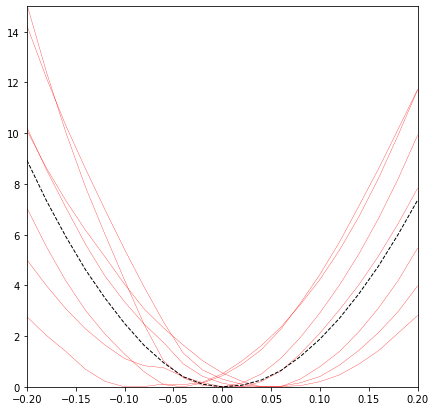

In [154]:

fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(1, 1, 1)
for profile_y in profiles_y_new[:len(profiles_y)] :
    ax.plot(profile_x, profile_y-np.min(profile_y), "-", linewidth=0.3, c="r")

av_y = []
for i in range(len(profile_x)) :
    av_y.append(np.mean([y[i]-np.min(y) for y in profiles_y_new[:len(profiles_y)]]))
ax.plot(profile_x, av_y - np.min(av_y), "--", linewidth=1, c="k")
    
ax.set_ylim([0, 15])
ax.set_xlim(profile_x[0], profile_x[-1])
plt.show()

In [ ]:
#  Do highest stats asimov we can

n_asimov = 2000000

print(f"\nCreating new asimov for toy index {toy_idx}")
probe_ds  = density_model_TNLL.sample(n_asimov, [0])
probe_pdf = density_model_TNLL.evaluate(0, probe_ds)
QCD_logL_probe = QCD_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
EWK_logL_probe = EWK_logL_model.predict([dummy_zeros_probe, probe_ds], verbose=0)
QCD_L_probe    = np.exp(QCD_logL_probe)
EWK_L_probe    = np.exp(EWK_logL_probe)
reweight_pdf   = (sigma_EWK*EWK_L_probe + sigma_QCD*QCD_L_probe) / sigma_tot
probe_weights  = L * sigma_tot * reweight_pdf / (probe_pdf * len(probe_ds))

yp_NULL   = EvaluatorModel.predict([dummy_zeros_probe, QCD_logL_probe, probe_ds], verbose=0)
TNLL_NULL = np.sum(probe_weights)*yp_NULL

profile_y = []
for x in profile_x :
    sys.stdout.write(f"\nx = {x:.3f}")
    test_sig = np.ones (shape=(len(probe_ds),)) * x
    yp   = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL_probe, probe_ds], verbose=0))
    TNLL = -2 * (np.sum(probe_weights)*(yp-yp_NULL))
    sys.stdout.write(f"\rx = {x:.3f}  y = {TNLL:.3f}")
    profile_y.append(TNLL)

In [ ]:
'''
test_sig = np.ones (len(fake_white_datapoints))
yp0  = EvaluatorModel.predict([test_sig*0.000000, QCD_logL, fake_white_datapoints], verbose=0)
yp1  = EvaluatorModel.predict([test_sig*0.000090, QCD_logL, fake_white_datapoints], verbose=0)
yp2  = EvaluatorModel.predict([test_sig*0.000100, QCD_logL, fake_white_datapoints], verbose=0)

for i, (y0p, y1p, y2p, wp) in enumerate(zip(yp0, yp1, yp2, fake_datapoint_weights)) :
    print(i, y0p, y1p, wp, wp*(y0p-y1p))
    
print(np.sum(fake_datapoint_weights*yp1) - np.sum(fake_datapoint_weights*yp0))
print(fake_datapoint_weights*(yp1-yp0))
print(fake_datapoint_weights*yp0)
print(fake_datapoint_weights*yp1)
print(np.sum(fake_datapoint_weights*(yp1-yp0)))
print(np.sum(fake_datapoint_weights*yp0))
print(np.sum(fake_datapoint_weights*yp1))'''

In [ ]:
'''
variational_mean, variational_width = -0.08, -3

def variational_logpdf (x, m, w) :
    return scipy.stats.norm.logpdf(x, m, w)

logL = {}
dp_logL_NULL = np.longdouble(EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0))
logL_NULL    = np.sum(np.longdouble(fake_datapoint_weights)*dp_logL_NULL)
def ELBO (m, w, n=10, lower=-0.4, upper=0.4) :
    w = np.exp(w)
    def integrand (theta) :
        if type(theta) in [list, np.ndarray] :
            return [integrand(tp) for tp in theta]
        if theta not in logL :
            test_sig     = np.ones (shape=(len(fake_white_datapoints),)) * theta
            dp_logL      = np.longdouble(EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0))
            logL [theta] = np.sum ( np.longdouble(fake_datapoint_weights) * (dp_logL-dp_logL_NULL) ) #+ logL_NULL
        logq = variational_logpdf(theta, m, w)
        return np.exp(logq) * (logL [theta] - logq)
    ret = scipy.integrate.fixed_quad(integrand, lower, upper, n=n)[0]
    print(f"{m:.2}".ljust(10), f"{w:.2f}".ljust(10), f"{ret}")
    return ret

fit_ELBO = lambda p : - ELBO (p[0], p[1], n=20)

m = Minuit.from_array_func(fit_ELBO, [variational_mean, variational_width], [0.5, 0.5], errordef=1)
m.migrad()

print(m.values[0], np.exp(m.values[1]))'''

In [ ]:
'''from keras import backend as K

print("here 1")
logL_gradient  = K.gradients(FullEvaluatorModel.outputs, FullEvaluatorModel.inputs)

print("here 2")
logL_grad_func = K.function (FullEvaluatorModel.inputs, logL_gradient)

print("here 3")
logL_grads_SM = logL_grad_func([dummy_zeros.reshape((len(dummy_zeros),1))+best_x, 
                                dummy_zeros.reshape((len(dummy_zeros),1)),
                                fake_white_datapoints_SM])

print("here 4")
logL_grad_wrt_x_SM = np.array(logL_grads_SM[2])

print("here 5")
logL_SM = FullEvaluatorModel.predict([dummy_zeros.reshape((len(dummy_zeros),1))+best_x, 
                                      dummy_zeros.reshape((len(dummy_zeros),1)),
                                      fake_white_datapoints_SM])

print("here 6")
'''

In [ ]:
'''
print("here 3")
logL_grads_alt = logL_grad_func([dummy_zeros.reshape((len(dummy_zeros),1))+best_x+0.1, 
                                 dummy_zeros.reshape((len(dummy_zeros),1)),
                                 fake_white_datapoints_SM])

print("here 4")
logL_grad_wrt_x_alt = np.array(logL_grads_alt[2])

print("here 5")
logL_alt = FullEvaluatorModel.predict([dummy_zeros.reshape((len(dummy_zeros),1))+best_x+0.1,
                                       dummy_zeros.reshape((len(dummy_zeros),1)),
                                       fake_white_datapoints_SM])

print("here 6")'''

In [ ]:
'''fig = plt.figure(figsize=(10, 10))

for i in range(num_observables) :
    ax = fig.add_subplot(2, 2, i+1)

    TNLL_grad = -2. * ((logL_grad_wrt_x_alt[:,i]/logL_alt) - (logL_grad_wrt_x_SM[:,i]/logL_SM))
    ax.hist(np.fabs(TNLL_grad), bins=np.linspace(0, 0.04, 21), weights=fake_datapoint_weights, color=f"{0.1+0.1*i}", alpha=0.3)
    ax.text(0.6, 0.8, f"{np.std(np.fabs(TNLL_grad)):.4f}", transform=plt.gca().transAxes)

    ax.set_yscale("log")
    ax.set_title(f"Observable {i}")

plt.show()
    '''

In [ ]:
'''print(QCD_logL_model.evaluate([dummy_zeros, fake_white_datapoints_SM], 
                              dummy_zeros,
                              verbose=0))

print(QCD_logL_model.evaluate([dummy_zeros, fake_white_datapoints_SM], 
                              dummy_zeros,
                              sample_weight=np.full(fill_value=1, shape=dummy_zeros.shape),
                              verbose=0))

print(QCD_logL_model.evaluate([dummy_zeros, fake_white_datapoints_SM], 
                              dummy_zeros,
                              sample_weight=np.full(fill_value=2, shape=dummy_zeros.shape),
                              verbose=0))'''

In [ ]:
'''Ls = density_model_QCD.evaluate(0, fake_white_datapoints_SM)
print(np.sum(np.log(Ls)), np.mean(np.log(Ls)))'''

In [ ]:
'''print(QCD_models[0].evaluate(np.zeros(len(fake_datapoint_weights)), 
                       fake_white_datapoints_SM[:,0]))

print(QCD_models[1].evaluate([np.zeros(len(fake_datapoint_weights)), fake_white_datapoints_SM[:,:1]], 
                       fake_white_datapoints_SM[:,1]))

2.3675751178472604 + 1.6618719752872442'''

In [ ]:
'''from iminuit import Minuit

def model_get_NLL (self, params, dataset, weights=None) :
    num_observables = dataset.shape[1]
    params          = np.full(fill_value=params, shape=dataset[:,0].shape)
    NLL             = self.likelihood_models[0].model.evaluate(params, dataset[:,0], sample_weight=weights, verbose=0)
    for obs_idx in range(1, num_observables) :
        NLL = NLL + self.likelihood_models[obs_idx].model.evaluate([params, dataset[:,:obs_idx]], dataset[:,0], sample_weight=weights, verbose=0)
    return NLL

print("Calculating constants")
C_QCD   = sigma_QCD * np.exp(-fake_datapoint_weights*density_model_QCD.evaluate(0, fake_white_datapoints_SM))
C_SM    = C_QCD + sigma_EWK * np.exp(-fake_datapoint_weights*density_model_EWK.evaluate(0, fake_white_datapoints_SM))
TNLL_SM = np.sum(-2 * np.log(C_SM))

def get_TNLL_plus_const (c) :
    c = c[0]
    C_EWK = sigma_EWK * np.exp(-fake_datapoint_weights*density_model_EWK.evaluate(c, fake_white_datapoints_SM))
    TNLL  = -2 * np.log(C_QCD + C_EWK)
    TNLL  = np.sum(TNLL) - TNLL_SM
    print(c, TNLL)
    return TNLL

print("Fitting")
m = Minuit.from_array_func(get_TNLL_plus_const, [0,], [1.,], errordef=1.)
m.migrad(precision=0.02)
'''

In [ ]:
'''import tensorflow    as tf
from   keras.layers  import Input, Concatenate, Lambda
from   keras.models  import Model
import keras.backend as     K

ng = 15
sqrt_2pi = np.sqrt(2*np.pi)




def K_gauss_prob (x, mean, sigma) :
    return K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)

def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    #x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob

def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
        
def K_dataset_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_dataset_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def K_get_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_likelihood (eval_p, params_p, ng)

def K_get_log_likelihood (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, ng)

def combine_EWK_QCD_log_likelihoods (inputs) :
    logL_EWK, logL_QCD = inputs[0], inputs[1]
    return K.log((sigma_EWK*K.exp(logL_EWK) + sigma_QCD*K.exp(logL_QCD)) / sigma_tot)



EWK_models = [x.model for x in density_model_EWK.likelihood_models]
QCD_models = [x.model for x in density_model_QCD.likelihood_models]

for model in EWK_models :
    model.name = model.name.replace("QCD", "EWK")
    for layer in model.layers :
        layer.name = layer.name.replace("QCD", "EWK")

condition_input_layer_cWtil = Input((1,))
condition_input_layer_QCD   = Input((1,))
obs_input_layer             = Input((num_observables,))

EWK_logL_layers, QCD_logL_layers = [], []

for i, (EWK_model, QCD_model) in enumerate(zip(EWK_models, QCD_models)) :
    model_inputs_EWK = [condition_input_layer_cWtil]
    model_inputs_QCD = [condition_input_layer_QCD  ]
    if i > 0 :
        model_inputs_EWK.append(Lambda(lambda x : x[:, :i])(obs_input_layer))
        model_inputs_QCD.append(Lambda(lambda x : x[:, :i])(obs_input_layer))
    EWK_params = EWK_model(model_inputs_EWK)
    QCD_params = QCD_model(model_inputs_QCD)
    eval_p     = Lambda(lambda x : x[:, i])(obs_input_layer)
    EWK_logL_layers.append(Lambda(K_get_log_likelihood)([eval_p, EWK_params]))
    QCD_logL_layers.append(Lambda(K_get_log_likelihood)([eval_p, QCD_params]))

# combine layers
combine_layers = Lambda(lambda x : tf.add_n(x))
EWK_logL = combine_layers(EWK_logL_layers)
QCD_logL = combine_layers(QCD_logL_layers)

QCD_logL_model = Model([condition_input_layer_QCD, obs_input_layer], QCD_logL)
QCD_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

# combine EWK and QCD
QCD_precomputed_logL = Input((1,))
dataset_logL   = Lambda(combine_EWK_QCD_log_likelihoods)([EWK_logL, QCD_precomputed_logL])
EvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, QCD_precomputed_logL, obs_input_layer],
                       outputs = dataset_logL)
EvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 
'''

In [ ]:
'''#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start       = time.time()
dummy_zeros = np.zeros(shape=fake_datapoint_weights.shape)
QCD_logL    = QCD_logL_model.predict([dummy_zeros, fake_white_datapoints_SM], verbose=0)
end         = time.time()
print(f"QCD logL computed in {end-start:.2f}s")
'''

In [ ]:
'''dphi_j_j = np.linspace(-5, 5, 31)
m_jj     = np.full(fill_value=0.1  , shape=dphi_j_j.shape)
m_ll     = np.full(fill_value=0.1  , shape=dphi_j_j.shape)
dy_j_j   = np.full(fill_value=0.6  , shape=dphi_j_j.shape)
test_zeros = np.zeros(shape=dphi_j_j.shape)
test_sig   = np.ones(shape=dphi_j_j.shape) * 0.4

ds = np.array([m_jj, m_ll, dphi_j_j, dy_j_j]).transpose()
ds_full_sig_logL = FullEvaluatorModel.predict([test_sig, test_zeros, ds], verbose=0)

ds_QCD_logL  = QCD_logL_model.predict([test_zeros, ds], verbose=0)
ds_full_logL = FullEvaluatorModel.predict([test_zeros, test_zeros, ds], verbose=0)

plt.plot(ds_real[:,2], np.exp(ds_QCD_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_full_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_full_sig_logL)/np.exp(ds_full_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_EWK_logL))
plt.show()

plt.plot(ds_real[:,2], np.exp(ds_EWK_sig_logL)/np.exp(ds_EWK_logL))
plt.show()'''

In [ ]:
'''import scipy
from iminuit import Minuit
    
toy_fit_vals    = []
scans_record_L  = []
scans_record_CL = []

num_toys = 1

for toy_idx in range(num_toys) :

    #  Generate a large number of EWK datapoints at 0.
    #

    n_gen_EWK = int(np.min([max_n_gen_EWK, 4*sigma_EWK*L]))
    n_gen_QCD = int(np.min([max_n_gen_QCD, 4*sigma_QCD*L]))
    n_gen = n_gen_EWK + n_gen_QCD

    print(f"Generating {n_gen} fake datapoints")
    start = time.time()
    fake_white_datapoints_SM_EWK = density_model_EWK.sample(n_gen_EWK, [0])
    fake_white_datapoints_SM_QCD = density_model_QCD.sample(n_gen_QCD, [0])
    end = time.time()
    print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

    #  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

    start           = time.time()
    dummy_zeros_EWK = np.zeros(len(fake_white_datapoints_SM_EWK))
    dummy_zeros_QCD = np.zeros(len(fake_white_datapoints_SM_QCD))
    dummy_zeros     = np.concatenate([dummy_zeros_EWK, dummy_zeros_QCD])
    QCD_logL_EWK    = QCD_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
    QCD_logL_QCD    = QCD_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
    QCD_logL        = np.concatenate([QCD_logL_EWK, QCD_logL_QCD])
    QCD_L           = np.exp(QCD_logL)
    end             = time.time()
    print(f"QCD logL computed in {end-start:.2f}s")

    #  Compute logL_EWK here (to help with datapoint reweighting)

    start        = time.time()
    EWK_logL_EWK = EWK_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
    EWK_logL_QCD = EWK_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
    EWK_logL     = np.concatenate([EWK_logL_EWK, EWK_logL_QCD])
    EWK_L        = np.exp(EWK_logL)
    end          = time.time()
    print(f"EWK logL computed in {end-start:.2f}s")

    sigma_gen_EWK = n_gen_EWK / L
    sigma_gen_QCD = n_gen_QCD / L

    #fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * (sigma_EWK*EWK_L + sigma_QCD*QCD_L) / EWK_L
    fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * sigma_EWK * np.ones(len(fake_white_datapoints_SM_EWK)) 
    fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * sigma_QCD * np.ones(len(fake_white_datapoints_SM_QCD)) 
    fake_datapoint_weights     = np.concatenate([fake_datapoint_weights_EWK  , fake_datapoint_weights_QCD  ])
    fake_white_datapoints_SM   = np.concatenate([fake_white_datapoints_SM_EWK, fake_white_datapoints_SM_QCD])
    sum_weights = np.sum(fake_datapoint_weights)

    print(f"sigma_gen_EWK = {sigma_gen_EWK:.3f}")
    print(f"sigma_gen_QCD = {sigma_gen_QCD:.3f}")
    print(f"sigma_EWK     = {sigma_EWK:.3f}")
    print(f"sigma_QCD     = {sigma_QCD:.3f}")
    print(f"sigma_tot     = {sigma_tot:.3f}")
    print(f"sigma_asimov  = {sum_weights/L:.3f}")
    print(f"N_exp         = {sigma_tot*L:.3f}")
    print(f"N_asimov      = {sum_weights:.3f}")
    
    start   = time.time()
    SM_logL = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints_SM], verbose=0)
    end     = time.time()
    print(f"{end-start:.2f}s")
        
    ref_TNLL = -2 * np.sum (fake_datapoint_weights * SM_logL)
    
    def get_TNLL_plus_const (c) :
        global ref_TNLL
        cs = np.full(fill_value=c[0], shape=dummy_zeros.shape)
        TNLL  = -2 * np.sum (fake_datapoint_weights * EvaluatorModel.predict([cs, QCD_logL, fake_white_datapoints_SM], verbose=0))
        TNLL = TNLL - ref_TNLL
        return TNLL
    
    print("Doing scan")
    x = np.linspace(-0.4, 0.4, 17)
    y = []
    for xp in x :
        sys.stdout.write(f"\rDoing scan {xp:.3f} ********")
        yp = get_TNLL_plus_const([xp])
        y.append(yp)
    sys.stdout.write("\rScan complete ***************")
    y = y - np.min(y)
    plt.plot(x, y, "o--")
    plt.show()
    
    best_x, best_y = None, 1e30
    for xp, yp in zip(x, y) :
        if yp > best_y : continue
        best_x, best_y = xp, yp
    toy_fit_vals   .append(best_x)
    
    if np.fabs(best_x) < 0.4 :
        scans_record_L .append(y)
        scans_record_CL.append(1 - scipy.stats.chi2.cdf(y, 1))
        print(y)
        print(scans_record_CL[-1])
        plt.plot(x, [len([True for yp in scans_record_CL if yp[i]>0.05])/len(scans_record_CL) for i in range(len(x))])
        plt.show()

    print(f"==========    {toy_idx}    {best_x}    ==========")
    
    x = np.linspace(-.4, 0.4, 17)
    x = 0.5*(x[:-1] + x[1:])
    values, bins, _ = plt.hist(toy_fit_vals, bins=x)
    plt.errorbar(0.5*(bins[:-1]+bins[1:]), values, yerr=np.sqrt(values), fmt="o")
    plt.plot(x, (bins[1]-bins[0])*len(toy_fit_vals)*scipy.stats.norm.pdf(x, 0, np.std([xp for xp in toy_fit_vals if np.fabs(xp)<0.4])))
    plt.show()

'''

In [ ]:

'''#  Generate a large number of EWK datapoints at 0.
#

max_n_gen_EWK = int(2000)
max_n_gen_QCD = int(2000)

n_gen_EWK = int(np.min([max_n_gen_EWK, sigma_EWK*L]))
n_gen_QCD = int(np.min([max_n_gen_QCD, sigma_QCD*L]))
n_gen = n_gen_EWK + n_gen_QCD

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints_SM_EWK = density_model_EWK.sample(n_gen_EWK, [0])
fake_white_datapoints_SM_QCD = density_model_QCD.sample(n_gen_QCD, [0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start           = time.time()
dummy_zeros_EWK = np.zeros(len(fake_white_datapoints_SM_EWK))
dummy_zeros_QCD = np.zeros(len(fake_white_datapoints_SM_QCD))
dummy_zeros     = np.concatenate([dummy_zeros_EWK, dummy_zeros_QCD])
QCD_logL_EWK    = QCD_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
QCD_logL_QCD    = QCD_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
QCD_logL        = np.concatenate([QCD_logL_EWK, QCD_logL_QCD])
end             = time.time()
print(f"QCD logL computed in {end-start:.2f}s")

#  Compute logL_EWK here (to help with datapoint reweighting)

start        = time.time()
EWK_logL_EWK = EWK_logL_model.predict([dummy_zeros_EWK, fake_white_datapoints_SM_EWK], verbose=0)
EWK_logL_QCD = EWK_logL_model.predict([dummy_zeros_QCD, fake_white_datapoints_SM_QCD], verbose=0)
EWK_logL     = np.concatenate([EWK_logL_EWK, EWK_logL_QCD])
end          = time.time()
print(f"EWK logL computed in {end-start:.2f}s")

#  Get datapoint likelihoods at 0 hypothesis
#

QCD_L_EWK = np.exp(QCD_logL_EWK)
QCD_L_QCD = np.exp(QCD_logL_QCD)
EWK_L_EWK = np.exp(EWK_logL_EWK)
EWK_L_QCD = np.exp(EWK_logL_QCD)

sigma_gen_EWK = n_gen_EWK / L
sigma_gen_QCD = n_gen_QCD / L

fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * sigma_EWK * np.ones(len(fake_white_datapoints_SM_EWK)) # * (sigma_EWK + (sigma_QCD*QCD_L_EWK/EWK_L_EWK))
fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * sigma_QCD * np.ones(len(fake_white_datapoints_SM_QCD)) # * (sigma_QCD + (sigma_EWK*EWK_L_QCD/QCD_L_QCD))

fake_datapoint_weights   = np.concatenate([fake_datapoint_weights_EWK  , fake_datapoint_weights_QCD  ])
fake_white_datapoints_SM = np.concatenate([fake_white_datapoints_SM_EWK, fake_white_datapoints_SM_QCD])

sum_weights = np.sum(fake_datapoint_weights)
    
test_zeros = np.zeros(shape=(len(fake_white_datapoints_SM),))
test_sig   = np.ones (shape=(len(fake_white_datapoints_SM),)) * 0.4


start         = time.time()
QCD_L_test    = density_model_QCD.evaluate(0, fake_white_datapoints_SM)
EWK_L_test    = density_model_EWK.evaluate(0, fake_white_datapoints_SM)
comb_test     = np.log((sigma_QCD*QCD_L_test + sigma_EWK*EWK_L_test) / sigma_tot)
comb_test     = np.sum(fake_datapoint_weights*comb_test)
end           = time.time()
print(f"{end-start:.2f}s     {comb_test}    (density model and use numpy)")

start         = time.time()
QCD_logL_test = QCD_logL_model.predict([test_zeros, fake_white_datapoints_SM], verbose=0)
EWK_logL_test = QCD_logL_model.predict([test_zeros, fake_white_datapoints_SM], verbose=0)
comb_test     = np.log((sigma_QCD*np.exp(QCD_logL_test) + sigma_EWK*np.exp(EWK_logL_test)) / sigma_tot)
comb_test     = np.sum(fake_datapoint_weights*comb_test)
end           = time.time()
print(f"{end-start:.2f}s     {comb_test}    (logL model and use numpy)")

start         = time.time()
full_test     = FullEvaluatorModel.evaluate([test_zeros, test_zeros, fake_white_datapoints_SM], test_zeros, sample_weight=fake_datapoint_weights, verbose=0)
full_test     = sum_weights * full_test / n_gen
end           = time.time()
print(f"{end-start:.2f}s     {full_test}    (FEM eval with weights)")

start         = time.time()
full_test2    = EvaluatorModel.evaluate([test_zeros, QCD_logL_test, fake_white_datapoints_SM], test_zeros, sample_weight=fake_datapoint_weights, verbose=0)
full_test2    = sum_weights * full_test2 / n_gen
end           = time.time()
print(f"{end-start:.2f}s     {full_test2}    (EM eval with weights)")

start         = time.time()
full_test4    = FullEvaluatorModel.predict([test_zeros, test_zeros, fake_white_datapoints_SM], verbose=0)
full_test4    = np.sum(fake_datapoint_weights*full_test4)
end           = time.time()
print(f"{end-start:.2f}s     {full_test4}    (FEM eval then weight)")

start         = time.time()
full_test3    = EvaluatorModel.predict([test_zeros, QCD_logL_test, fake_white_datapoints_SM], verbose=0)
full_test3    = np.sum(fake_datapoint_weights*full_test3)
end           = time.time()
print(f"{end-start:.2f}s     {full_test3}    (EM eval then weight)")



ds_real = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)

QCD_logL = QCD_logL_model.predict([test_zeros, fake_white_datapoints_SM], verbose=0)

x, y = [], []
for i in np.linspace(-0.2, 0.2, 21) :
    sys.stdout.write(f"\r{i}  *************************")
    test_sig = np.ones (shape=(len(fake_white_datapoints_SM),)) * i
    
    yp = EvaluatorModel.predict([test_sig, QCD_logL_test, fake_white_datapoints_SM], verbose=0)
    
    x.append(i)
    y.append(-2*np.sum(fake_datapoint_weights*yp)) 
plt.plot(x, y - np.min(y))
plt.show()
plt.plot(x, y - np.min(y))
plt.gca().set_ylim([0, 10])
plt.show()'''

'''
ds_full_logL     = FullEvaluatorModel.predict([test_zeros, test_zeros, fake_white_datapoints_SM], verbose=0)
ds_full_sig_logL = FullEvaluatorModel.predict([test_sig  , test_zeros, fake_white_datapoints_SM], verbose=0)

for obs in range(4) :
    w1 = fake_datapoint_weights
    w2 = fake_datapoint_weights * np.exp(ds_full_sig_logL-ds_full_logL)
    vals1, bins1 = np.histogram(ds_real[:,obs], weights=w1)
    vals2, _     = np.histogram(ds_real[:,obs], weights=w2   , bins=bins1)
    fe1, fe2     = 1 / np.sqrt(vals1), 1 / np.sqrt(vals2)
    f            = vals2 / vals1
    
    plt.errorbar(0.5*(bins1[1:]+bins1[:-1]), f, yerr=f*fe2)
    plt.gca()
    plt.show()'''



In [ ]:
'''#  Generate a large number of EWK datapoints at 0.
#
n_gen_EWK = int(5000)
n_gen_QCD = int(0)
n_gen = n_gen_EWK + n_gen_QCD

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints_EWK = density_model_EWK.sample(n_gen_EWK, [0])
fake_white_datapoints_QCD = density_model_QCD.sample(n_gen_QCD, [0])
fake_white_datapoints     = np.concatenate([fake_white_datapoints_EWK, fake_white_datapoints_QCD])
print(f"{n_gen} datapoints generated at cWtil=0 in {int(time.time()-start):.0f}s")

#  Compute logL_QCD here (to avoid performing the same calc every time we eval logL_tot)

start       = time.time()
dummy_zeros = np.zeros(len(fake_white_datapoints))
QCD_logL    = QCD_logL_model.predict([dummy_zeros, fake_white_datapoints], verbose=0)
print(f"QCD logL computed in {time.time()-start:.2f}s")

#  Compute logL_EWK here (to help with datapoint reweighting)

start    = time.time()
EWK_logL = EWK_logL_model.predict([dummy_zeros, fake_white_datapoints], verbose=0)
print(f"EWK logL computed in {time.time()-start:.2f}s")

#  Get datapoint likelihoods at 0 hypothesis
#

start    = time.time()
logL_NULL = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
L_NULL    = np.exp(logL_NULL)
print(f"SM logL computed in {time.time()-start:.2f}s")
'''